# CREDIT FRAUD DETECTOR

## INTRODUCTION

Fraud detection has already been the main focus of the banking sector for a long time. Fraud impacts an organization in several areas including financial, operational, and psychological. Specifically, It not only loses money but also loses reputation, goodwill, and customer relations.

In this project, I will apply various predictive models to help the company recognize fraudulent credit card transactions so that customers are not charged for items they did not purchase. The dataset I used in this project contains transactions made by credit cards in September 2013 by European cardholders. It contains only numerical input variables which are the result of a PCA transformation because of confidentiality issues.

## GOAL

Understand the distribution and grab a sense of our dataset

Try different basic models and ensemble models to see how accurate they predict and choose the optimal one for this case

Apply and evaluate some common techniques of resampling like Random Under Sampling, NearMiss, Random Over Sampling, and SMOTE to due with an imbalanced dataset.

## Reference

This project was inspired by:
1) Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélien Géron
2) Special Thanks to Shahules - Link: https://www.kaggle.com/code/shahules/tackling-class-imbalance
3) Special Thanks to Janio Martinez Bachmann - Link: https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/comments
4) Special Thanks to Pham Dinh Khanh - Link: https://phamdinhkhanh.github.io/2020/02/17/ImbalancedData.html#48-th%E1%BB%AD-nghi%E1%BB%87m-nhi%E1%BB%81u-ph%C6%B0%C6%A1ng-ph%C3%A1p-kh%C3%A1c-nhau

### I. INSTALL LIBRARY

In [1]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, RandomOverSampler
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC)
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.base import BaseSampler
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve,roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

### II. GATHER SENSE OF OUR DATA

The dataset comprises transaction records, with all features except 'Amount' and 'Time' anonymized through Principal Component Analysis (PCA) transformation to ensure confidentiality.

**INSIGHT:**

Data Integrity: No missing values were found, ensuring data completeness for analysis.

Transaction Amounts: The distribution of transaction amounts skews right, suggesting a predominance of smaller transactions with occasional outliers. The mean transaction value stands at approximately $88 USD.

Temporal Scope: Spanning a duration of two days (equivalent to 172,800 seconds), the dataset captures a snapshot of transactional activity.

Imbalanced Dataset: Of the 284,807 transactions recorded, only 492 instances of fraud were identified, signifying a highly imbalanced dataset. Fraudulent transactions represent a mere 0.172% of the total, underscoring the rarity of such occurrences.

In [3]:
df = pd.read_csv("/Users/nguyenminhhieu/Downloads/Basic Python/creditcard.csv")

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

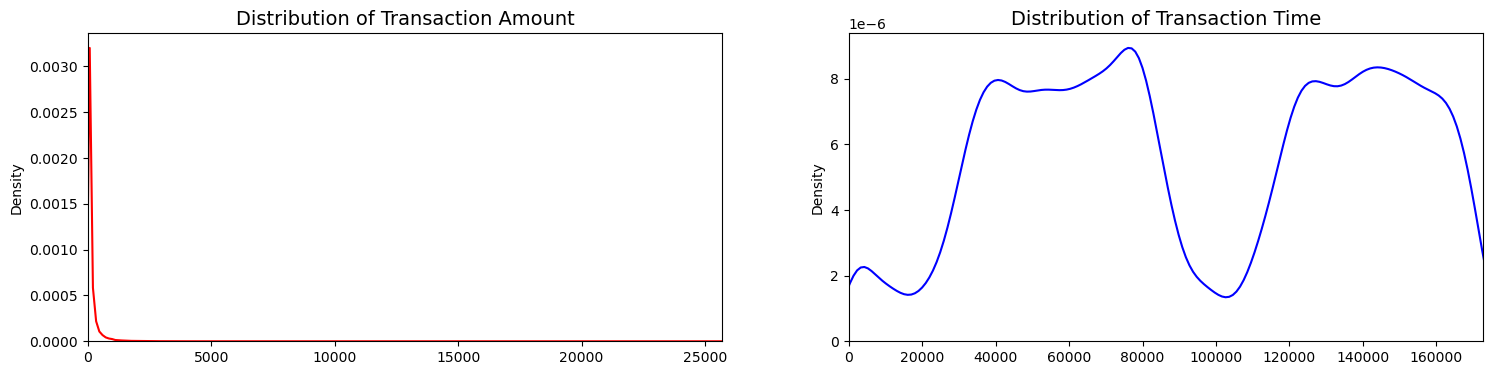

In [8]:
# Plot distribution of Transaction Amount and Time

fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.kdeplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.kdeplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])


plt.show()

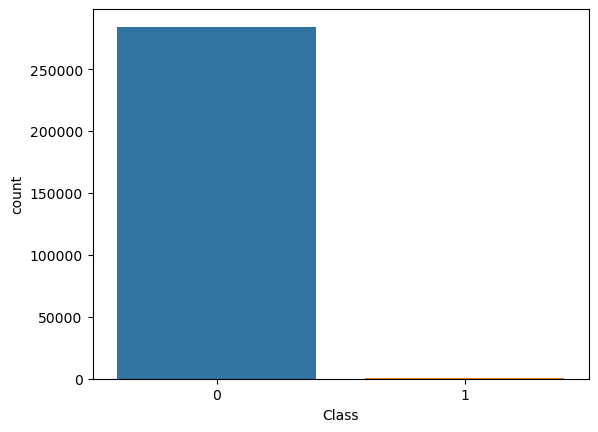

In [9]:
# Plot distribution of Class
ax = sns.countplot(df, x=df["Class"])
plt.show()

In [10]:
fraud_instance = len(df[df["Class"] == 1])
non_fraud_instance = len(df[df["Class"] == 0])

print("Fraud Instance: ", fraud_instance, round(fraud_instance/len(df)*100,2))
print("Non-Fraud Instance: ", non_fraud_instance, round(non_fraud_instance/len(df)*100,2))

Fraud Instance:  492 0.17
Non-Fraud Instance:  284315 99.83


**Note:** Indeed, the high class imbalance in the original dataset poses a significant challenge for training a robust fraud detection model. When the majority class (non-fraudulent transactions) vastly outweighs the minority class (fraudulent transactions), the model tends to be biased towards predicting the majority class, resulting in poor detection of fraudulent patterns. The important you want the model to do is detect the pattern of the fraud transactions.

### III. DATA PREPROCESSING

**a) Scaling Feature**

As I already said previously, almost the features are scaled so we also should to scale Time and Amount to robust the performance of model. I will apply the StandardScaler for Time and RobustScaler for Money. The reason why I use RobustScaler for Money because this distribution is very skewed.

In [11]:
## Scaled Time and Amount
from sklearn.preprocessing import StandardScaler, RobustScaler
std_scaler = StandardScaler()
rb_scaler = RobustScaler()

df["Amount_scaled"] = rb_scaler.fit_transform(df["Amount"].values.reshape(-1,1))
df["Time_scaled"] = std_scaler.fit_transform(df["Time"].values.reshape(-1,1))

df.drop(["Time","Amount"], axis =1 , inplace = True )

**b) Split The Original Dataset**



Before exploring various models and techniques, the original dataset will be divided into training and testing sets using the StratifiedShuffleSplit method. This approach maintains the proportion of each class in both the training and testing sets, ensuring a representative sample for subsequent analysis.

Keeping a separate test set untouched by any resampling techniques enables us to assess how well the models generalize to unseen data. This ensures that the performance metrics obtained during evaluation accurately reflect the model's effectiveness in real-world applications.

In [12]:
# Train and Test Split
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42) 

for train_index, test_index in split.split(df, df["Class"]):
        strat_train_set = df.loc[train_index]
        strat_test_set = df.loc[test_index]

In [13]:
X_train = strat_train_set.drop("Class", axis = 1)
y_train = strat_train_set["Class"]
X_test = strat_test_set.drop("Class", axis = 1)
y_test = strat_test_set["Class"]

In [14]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [15]:
X_train.shape

(227845, 30)

In [16]:
X_test.shape

(56962, 30)

In [17]:
train_counts = np.bincount(y_train)
train_proportions = train_counts / len(y_train)

test_counts = np.bincount(y_test)
test_proportions = test_counts / len(y_test)
print("Train proportions:", train_proportions)
print("Test proportions:", test_proportions)

Train proportions: [0.99827075 0.00172925]
Test proportions: [0.99827955 0.00172045]


### IV. CHOOSSING THE RIGHT METRIC

In cases of highly imbalanced datasets, where one class vastly outweighs the others, relying solely on accuracy can be misleading. This is because a model may achieve high accuracy simply by consistently predicting the majority class. To address this, alternative evaluation metrics such as precision, recall, and F1-score are essential for a more comprehensive assessment of model performance.

- **Precision:** This metric quantifies the accuracy of positive predictions by measuring the proportion of true positive predictions among all instances predicted as positive. It highlights the model's ability to correctly identify positive cases, minimizing false positives. High precision is crucial in scenarios where misclassifying positive instances can lead to significant consequences.

- **Recall:** Also known as sensitivity or the true positive rate, recall assesses the model's ability to capture all positive instances by measuring the proportion of true positives among all actual positive instances in the dataset. It emphasizes the model's ability to avoid false negatives, ensuring that positive cases are not overlooked. High recall is vital when it is important to identify all positive instances, even at the expense of potentially higher false positives.

- **F1 Score:** The F1 score strikes a balance between precision and recall by taking their harmonic mean. It provides a single metric that combines both precision and recall, offering a holistic view of the model's performance. The F1 score is particularly useful in situations where there is a significant class imbalance, as it considers both the false positive and false negative rates.

By considering precision, recall, and F1-score together, one can obtain a more nuanced understanding of the model's strengths and weaknesses in classification tasks, especially in scenarios where class distributions are uneven."


### V. LOGISTIC REGRESSION
In this section, I will employ Logistic Regression as the base classifier to tackle the issue of an imbalanced dataset. Additionally, I will explore the effectiveness of combining it with various resampling techniques. The objective is to identify the optimal solution for handling the class imbalance.

**a. Baseline Logistic Regression**

GridSearchCV is used to determine the paremeters that gives the best predictive score for the classifiers.

In [18]:
# Train model using hyperparameter tuning
def training_model_hyperparameter(model, scoring, params_grid, X_train, y_train):
    folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state=100)
    grid = GridSearchCV(estimator = model, scoring=scoring, param_grid = params_grid, cv = folds, 
                           verbose=0, return_train_score=True, n_jobs=3, error_score='raise')
    grid.fit(X_train, y_train)
            
    return grid

In [19]:
# Predict value and propability of training and testing data
def prediction_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    return y_train_pred, y_train_pred_prob, y_test_pred, y_test_pred_prob

In [20]:
# Hyperparameter tuning
lr = LogisticRegression(solver = "liblinear", random_state=42)
lr_param_grid = {"penalty": ['l1', 'l2'], 'C': [0.5 , 1, 1.5]}
lr_grid = training_model_hyperparameter(lr,'roc_auc', lr_param_grid, X_train, y_train)

In [21]:
lr_grid.best_params_

{'C': 0.5, 'penalty': 'l2'}

In [22]:
y_train_pred_lr, y_train_pred_lr_prob, y_test_pred_lr, y_test_pred_lr_prob = prediction_model(lr_grid, X_train, y_train, X_test, y_test)

In [23]:
# Logistic Regresion Performance
base_roc_score = roc_auc_score(y_test, y_test_pred_lr_prob)
base_f1_score = f1_score(y_test, y_test_pred_lr)
print('LR roc score on test: ', base_roc_score)
print(classification_report(y_test, y_test_pred_lr)) 

LR roc score on test:  0.9825602511685596
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.58      0.68        98

    accuracy                           1.00     56962
   macro avg       0.91      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962



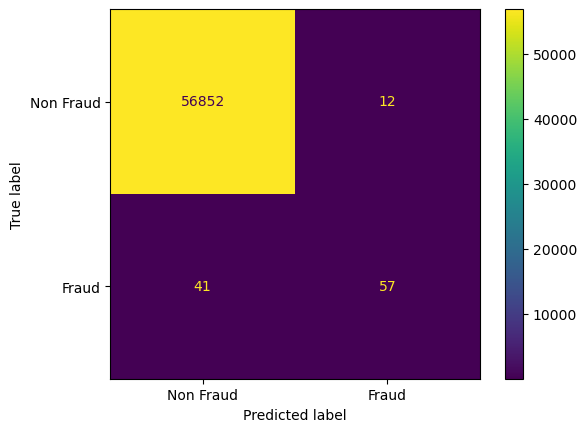

In [24]:
#Plot Confusion Matrix
cm = confusion_matrix(y_test,y_test_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

**Peformance of base Logistic Regression**

Certainly! It seems like the classifier performs admirably in predicting the majority class (non-fraud) with precision and recall scores close to 1, indicating high accuracy in identifying non-fraudulent transactions. However, when it comes to the minority class (fraud), the model's performance drops significantly, with only a 83% and 58% precision score and recall score respectively.

This discrepancy underscores the challenge posed by imbalanced datasets, where the model tends to be biased towards the majority class due to its prevalence in the data. To improve model performance, we will try to apply various techniques at the followwing part

In [25]:
#Baseline Model
lr_base_model = LogisticRegression(solver = "liblinear", penalty= "l2" , C= 0.5, random_state=42)

**b) Random Under Sampling**

Random under-sampling aims to balance the class distribution by reducing the number of instances in the majority class to match that of the minority class. While this approach can help address the imbalance issue, it comes with the drawback of information loss from the majority class.

By discarding instances from the majority class, the resulting dataset may not fully represent the original distribution of non-fraud cases. Consequently, predictive models trained on this under-sampled data may not capture the full complexity of the non-fraud class, leading to poorer performance in predicting non-fraudulent transactions.

However, the advantage of random under-sampling lies in its ability to emphasize the patterns of the minority class. By reducing the dominance of the majority class, the model is encouraged to focus more on the characteristics and features that distinguish fraudulent transactions, potentially improving its ability to detect fraud.

It's important to weigh the trade-offs of using random under-sampling and consider the specific requirements of the problem at hand. While it can be effective in boosting the performance of models in detecting minority class instances, it's essential to be mindful of the potential loss of information from the majority class and its impact on overall model performance.

In [26]:
# Using Scatter plot to see how data relocates after applying resampling technique
def plot_2d_space(X, y, X_train, y_train ,label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
   
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, alpha = 0.5
        )
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(
            X_train[y_train==l, 0],
            X_train[y_train==l, 1],
            c=c, label=l, marker=m, alpha = 0.5
        )
    ax1.set_xlim(-40,10)
    ax1.set_ylim(-50,30)
    ax2.set_xlim(-40,10)
    ax2.set_ylim(-50,30)
    ax1.set_title(label)
    ax2.set_title('original data')
    plt.legend(loc='upper right')
    plt.show()

In [27]:
# Resampling with Random Under Sampler
rus = RandomUnderSampler(random_state = 42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_rus).items()))

[(0, 394), (1, 394)]


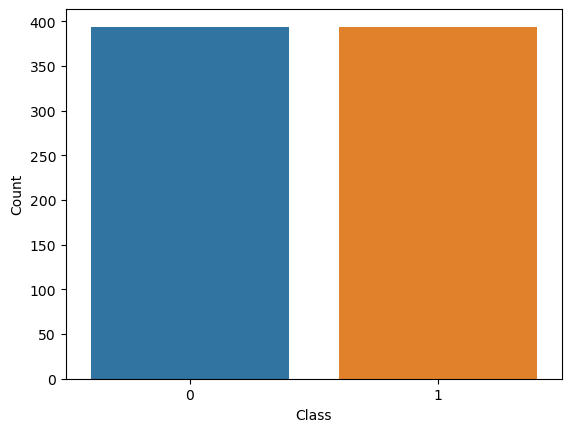

In [28]:
y_counts = Counter(y_train_rus)

# Convert Counter object to lists
class_labels = list(y_counts.keys())
class_counts = list(y_counts.values())

sns.barplot(y=class_counts, x=class_labels)
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

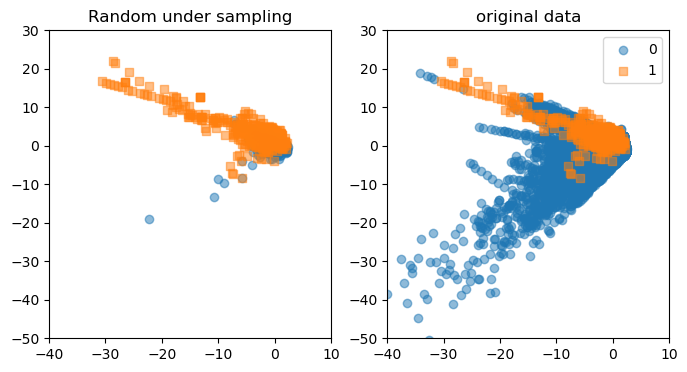

In [29]:
#Scatter plot resampling distribution
plot_2d_space(X_train_rus, y_train_rus, X_train, y_train,'Random under sampling')

**c) Dimensionality Reduction and Clustering**

In this section, we will apply some dimensionality reduction and clustering algorithms, including:
+ Principal Component Analysis (PCA)
+ RBF Kernel PCA
+ T-SNE

**Insight:**
T-SNE is effective at classifying the under-sampled dataset into two distinct categories: fraud and non-fraud. This success suggests that the underlying structure of the data is sufficiently separable, which bodes well for the performance of subsequent predictive models.

In [30]:
#PCA Implementation
pca = PCA(n_components = 2, random_state = 42)
X_reduced_pca = pca.fit_transform(X_train_rus)

#T-SNE Implementation
tsne = TSNE(n_components = 2, random_state = 42)
X_reduced_tsne = tsne.fit_transform(X_train_rus)

#RBF Kernel PCA Implementation
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced_rbf = rbf_pca.fit_transform(X_train_rus)

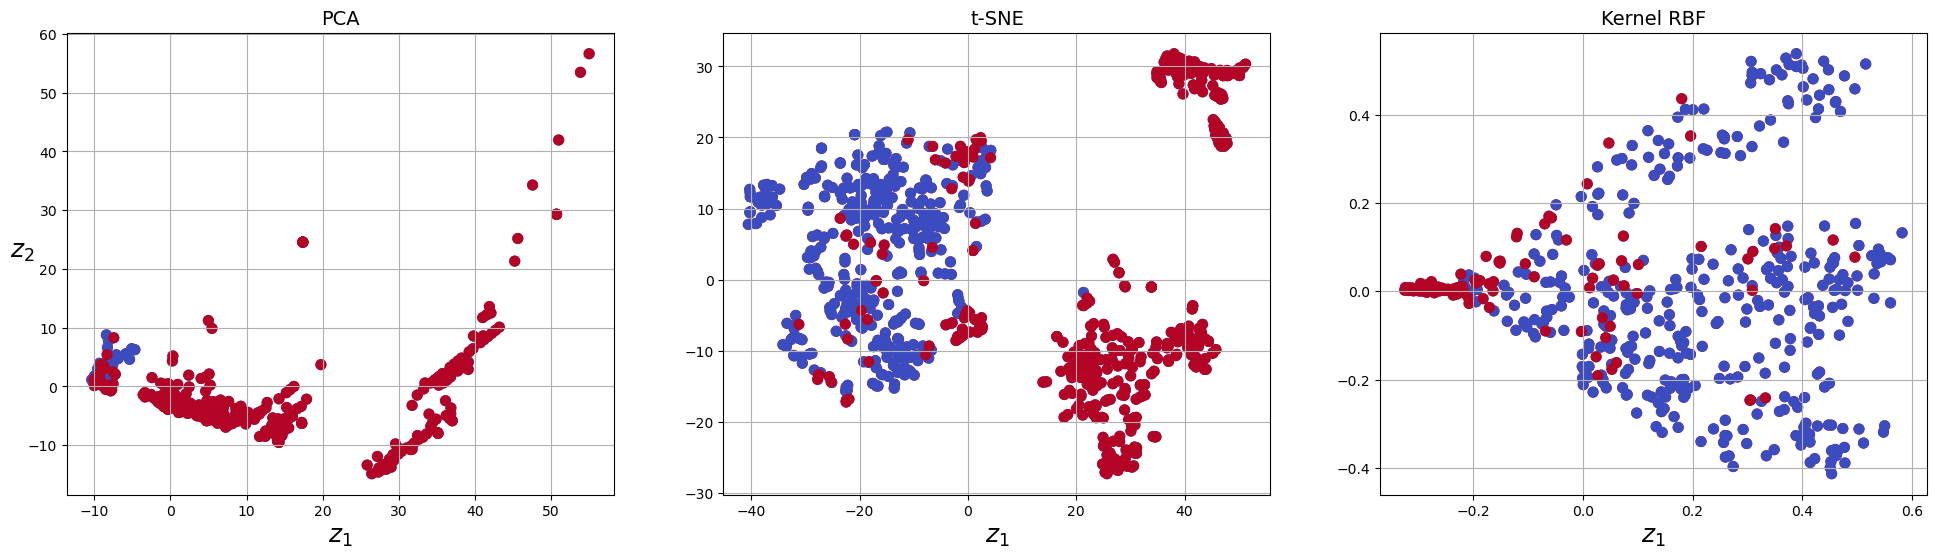

In [31]:
# Scatter Plot of PCA, T-SNE and Kernel RBF
titles = ["PCA", "t-SNE", "Kernel RBF"]

plt.figure(figsize=(24,6))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_pca, X_reduced_tsne, X_reduced_rbf)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c= (y_train_rus == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c= (y_train_rus == 1), cmap='coolwarm', label='Fraud', linewidths=2)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

**d) Train and Evaluate model using Random Under Sampling**

As we said before, when applying random under-sampling, the model's performance in detecting non-fraud cases might suffer due to the loss of information from the majority class. This information loss can lead to overfitting to the minority class and, consequently, poorer performance on the majority class.

The performance metrics we provided for Logistic Regression with Random Under Sampling (RUS) on the test dataset indicate some notable results:

- Precision: The precision for the minority class (fraudulent transactions) is low at 0.06, indicating that out of all instances predicted as fraud, only 6% are actually fraudulent. However, the precision for the majority class (non-fraudulent transactions) is high at 1.00, indicating a very low rate of false positives for non-fraudulent transactions.

- Recall: The recall for the minority class is relatively high at 0.92, indicating that the model is able to capture a significant portion of the actual fraudulent transactions. However, the recall for the majority class is lower at 0.97, suggesting that a small percentage of non-fraudulent transactions are being misclassified as fraudulent.

- F1-score: The F1-score for the minority class is low at 0.11, reflecting the imbalance between precision and recall for fraud predictions.

**Note:** The trade-offs between precision and recall for the minority class are evident, reflecting the challenge of balancing the model's ability to correctly identify fraudulent transactions while minimizing false positives. The high recall indicates that the model is effective at capturing most instances of fraud, but the low precision suggests that it also generates a significant number of false positives.

In [32]:
# Evaluate model's performance on the training set
rus_lr = lr_base_model.fit(X_train_rus, y_train_rus)
rus_predictions = rus_lr.predict_proba(X_train_rus)
rus_pred_label = rus_lr.predict(X_train_rus) 
rus_roc_score = roc_auc_score(y_train_rus, rus_predictions[:,1])
print('LR with Random Under Sampling roc score on train: ', rus_roc_score)
print(classification_report(y_train_rus, rus_pred_label)) 

LR with Random Under Sampling roc score on train:  0.9864206756164808
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       394
           1       0.98      0.92      0.95       394

    accuracy                           0.95       788
   macro avg       0.95      0.95      0.95       788
weighted avg       0.95      0.95      0.95       788



In [33]:
# Evaluate model's performance on the test set
rus_lr = lr_base_model.fit(X_train_rus, y_train_rus)
rus_predictions = rus_lr.predict_proba(X_test)
rus_pred_label = rus_lr.predict(X_test) 
rus_roc_score = roc_auc_score(y_test, rus_predictions[:,1])
print('LR with Random Under Sampling roc score on test: ', rus_roc_score)
print(classification_report(y_test, rus_pred_label)) 

LR with Random Under Sampling roc score on test:  0.9801709126250387
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



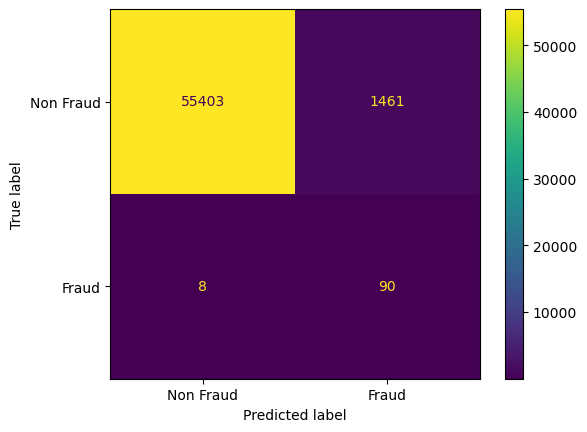

In [34]:
#Plot Confusion Matrix
rus_lr_cm = confusion_matrix(y_test, rus_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=rus_lr_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

**e) NearMiss**

It's not uncommon for NearMiss to exhibit similar characteristics to Random Under Sampling (RUS), including potential overfitting to the minority class (fraudulent cases) and slightly poorer overall performance compared to RUS.

In [35]:
# Resampling with NearMiss
nearmiss = NearMiss(version=3, n_neighbors_ver3=4)
X_train_nearmiss, y_train_nearmiss = nearmiss.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_nearmiss).items()))

[(0, 394), (1, 394)]


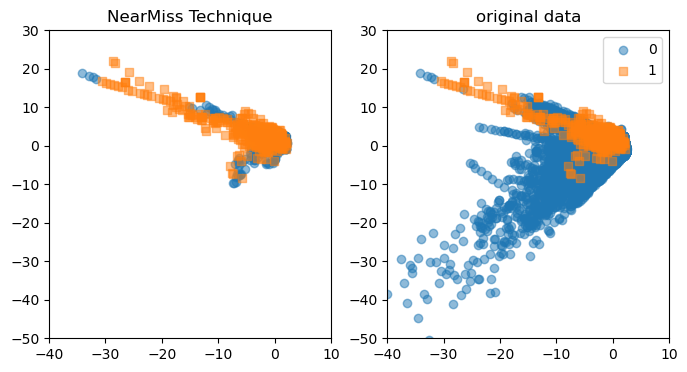

In [36]:
#Scatter plot resampling distribution
plot_2d_space(X_train_nearmiss, y_train_nearmiss, X_train, y_train,'NearMiss Technique')

In [37]:
# Evaluate model's performance on the test set
nearmiss_lr = lr_base_model.fit(X_train_nearmiss, y_train_nearmiss)
nearmiss_predictions =nearmiss_lr.predict_proba(X_test)
nearmiss_pred_label = nearmiss_lr.predict(X_test) 
nearmiss_roc_score = roc_auc_score(y_test, nearmiss_predictions[:,1])
print('LR with NearMiss roc score on test: ', nearmiss_roc_score)
print(classification_report(y_test, nearmiss_pred_label))

LR with NearMiss roc score on test:  0.9234264998908961
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56864
           1       0.02      0.79      0.03        98

    accuracy                           0.91     56962
   macro avg       0.51      0.85      0.49     56962
weighted avg       1.00      0.91      0.95     56962



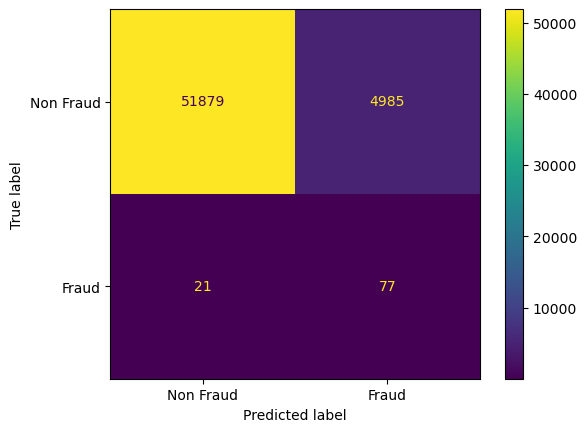

In [38]:
#Plot Confusion Matrix
nm_lr_cm = confusion_matrix(y_test, nearmiss_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=nm_lr_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

**f) Random Over Sampling**

Random Over Sampling (ROS) is a technique used to balance the dataset by duplicating instances of the minority class, thereby increasing its representation in the dataset. Unlike Random Under Sampling (RUS), which discards instances from the majority class, ROS retains all instances from both classes, ensuring that the original information is preserved.

However, one potential drawback of ROS is that it can lead to an increase in training time, especially for algorithms sensitive to dataset size. Duplicating minority class instances results in a larger dataset, which may require more computational resources and time to train the model.

**Performance of Logistic Regression with Random Over Sampling**: Like the Random under sampling, the model have a tendency to overfitting to the minority class (0,06 for precison and 0,91 for recall) but better in classifying the non-fraud case

In [39]:
# Resampling with Random Over Sampling
ros = RandomOverSampler(random_state =42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_ros).items()))

[(0, 227451), (1, 227451)]


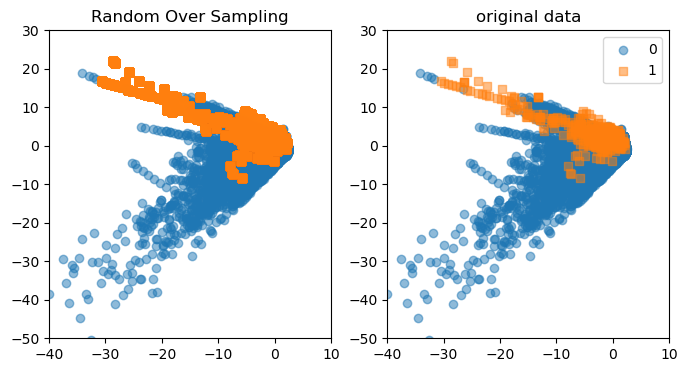

In [40]:
#Scatter plot resampling distribution
plot_2d_space(X_train_ros, y_train_ros, X_train, y_train,'Random Over Sampling')

In [41]:
# Evaluate model's performance on the test set
ros_lr = lr_base_model.fit(X_train_ros, y_train_ros)
ros_predictions =ros_lr.predict_proba(X_test)
ros_pred_label = ros_lr.predict(X_test) 
ros_roc_score = roc_auc_score(y_test, ros_predictions[:,1])
print('LR with Random Over Sampling roc score on test: ', ros_roc_score)
print(classification_report(y_test, ros_pred_label))

LR with Random Over Sampling roc score on test:  0.9810320794046374
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



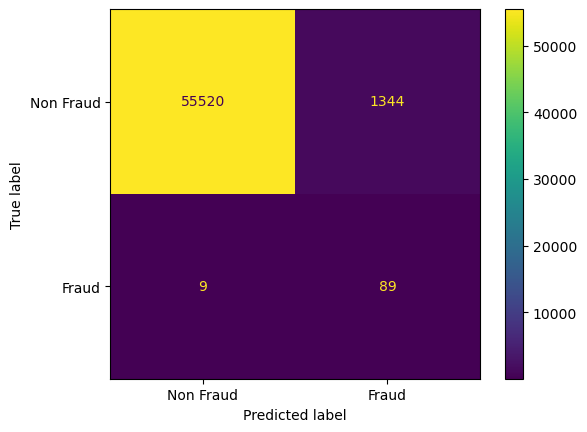

In [42]:
#Plot Confusion Matrix
ros_lr_cm = confusion_matrix(y_test, ros_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=ros_lr_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

**e) SMOTE**

In this section, I will implement various SMOTE and ADASYN techniques to resample the dataset. These techniques involve creating synthetic samples for the minority class to balance the class distribution while retaining the original information.
- SMOTE
- BorderlineSMOTE
- SVMSMOTE
- ADASYN

After evaluating the performance of each model, we can compare the results to determine which SMOTE method, such as SVMSMOTE, exhibits the best performance for our dataset and classification task.

**Performance of Logistic Regression with SVM SMOTE**: 
Among the sampling techniques we've applied so far, SVMSMOTE appears to be the most effective. It has yielded the highest F1-score of 0.21 for the minority class, indicating a good balance between precision and recall for identifying fraudulent transactions. 

------------------------------------------------
SMOTE method:  SMOTE
lr roc score on test:  0.9820910866456881
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.93      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



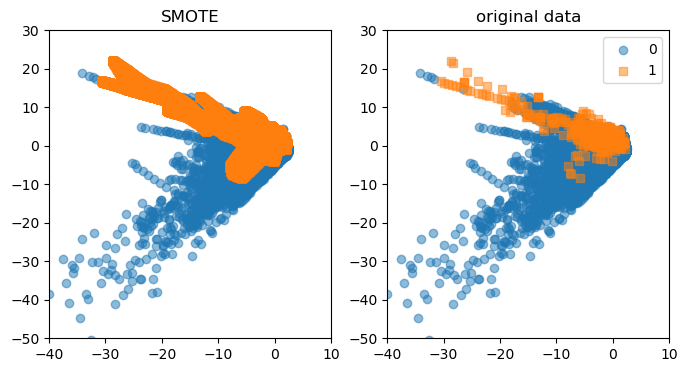

------------------------------------------------
SMOTE method:  BorderlineSMOTE
lr roc score on test:  0.9445531694669991
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.87      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.59     56962
weighted avg       1.00      0.99      0.99     56962



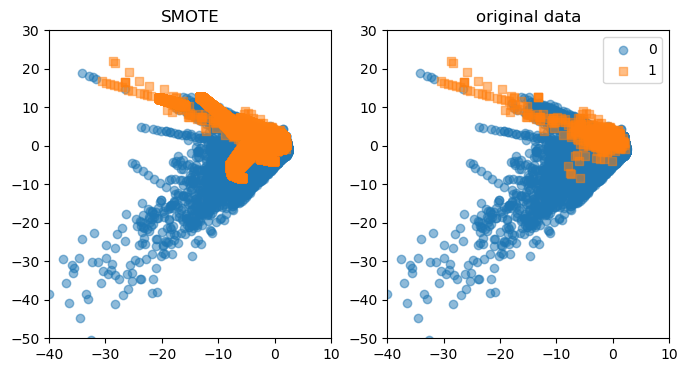

------------------------------------------------
SMOTE method:  SVMSMOTE
lr roc score on test:  0.9567230944150309
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.87      0.21        98

    accuracy                           0.99     56962
   macro avg       0.56      0.93      0.60     56962
weighted avg       1.00      0.99      0.99     56962



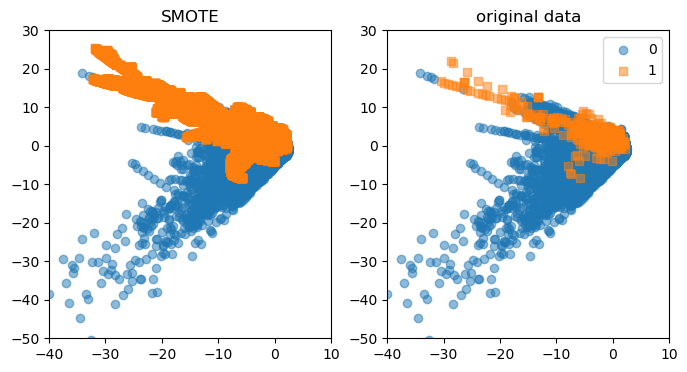

------------------------------------------------
SMOTE method:  ADASYN
lr roc score on test:  0.982171209789487
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56864
           1       0.02      0.97      0.04        98

    accuracy                           0.91     56962
   macro avg       0.51      0.94      0.49     56962
weighted avg       1.00      0.91      0.95     56962



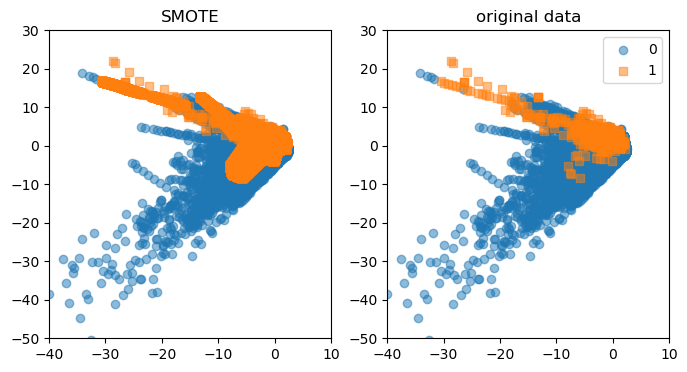

In [43]:
# Resampling with various SMOTE techniques
smotes = {0 : 'SMOTE',
          1 : 'BorderlineSMOTE',
          2 : 'SVMSMOTE',
          3 : 'ADASYN'}


for i, sampler in enumerate((SMOTE(sampling_strategy = 1, random_state=0),
                BorderlineSMOTE(sampling_strategy = 1, random_state=0, kind='borderline-1'),
                SVMSMOTE(sampling_strategy = 1, random_state=0),
                ADASYN(sampling_strategy = 1, random_state=0))):
    X_train_sm, y_train_sm = sampler.fit_resample(X_train, y_train)
    pipe_line = make_pipeline(sampler, lr_base_model)
    pipe_line.fit(X_train, y_train)
    lr_predictions = pipe_line.predict_proba(X_test)
    lr_pred_label = pipe_line.predict(X_test) 
    lr_roc_score = roc_auc_score(y_test, lr_predictions[:,1])
    print('------------------------------------------------')
    print('SMOTE method: ', smotes[i])
    print('lr roc score on test: ', lr_roc_score)
    print(classification_report(y_test, lr_pred_label))
    plot_2d_space(X_train_sm, y_train_sm, X_train, y_train,'SMOTE')

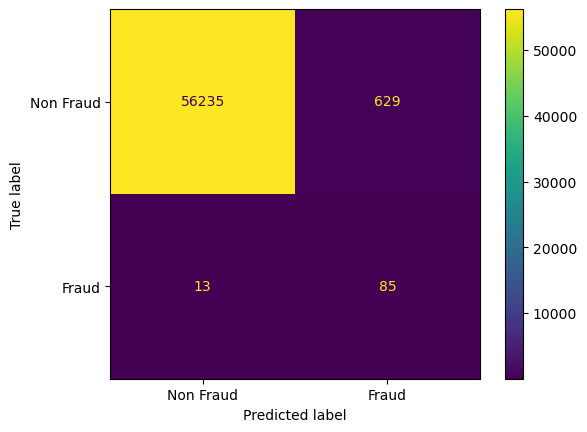

In [44]:
#Plot Confusion Matrix
svm_smote = SVMSMOTE(sampling_strategy = 1, random_state=0)
X_train_svmsmote, y_train_svmsmote = svm_smote.fit_resample(X_train, y_train)

svm_lr = lr_base_model.fit(X_train_svmsmote, y_train_svmsmote)
svm_predictions =svm_lr.predict_proba(X_test)
svm_pred_label = svm_lr.predict(X_test) 

svm_lr_cm = confusion_matrix(y_test, svm_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=svm_lr_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

**f) Model Penalty**

Adding penalties or adjusting class weights in the model is another effective approach to handle imbalanced datasets. This technique involves modifying the cost function during model training to penalize misclassifications differently based on the class distribution. Essentially, it assigns a higher penalty to errors made on the minority class, encouraging the model to prioritize correctly predicting these instances.

**Performance of Logistic Regression with penalty:** 
- Logistic Regression with penalties produce considerable improvement in comparision to baseline model. We see that both precision, recall and f1 score are higher than the baseline model. This is the most positive result in the models so far. 
- The F1-score, in particular, has increased by approximately 9.3% from 0.68 to 0.75, which indicates a substantial enhancement in the model's ability to balance precision and recall, especially for the minority class.
- The model can now detect approximately 79% of the fraud cases with a precision of 73%. 

In [45]:
# Logistic Regression with penalties 
lr_weight_model = LogisticRegression(solver = "liblinear", 
                                   penalty= "l2" , 
                                   class_weight={0: 0.1, 1: 0.9},
                                   C= 0.5, 
                                   random_state=42)

In [46]:
# Evaluate model's performance on the test set
lr_pen = lr_weight_model.fit(X_train, y_train)
lr_pen_predictions =lr_pen.predict_proba(X_test)
lr_pen_pred_label = lr_pen.predict(X_test) 
lr_pen_roc_score = roc_auc_score(y_test, lr_pen_predictions[:,1])
print('LR with Class Weight roc score on test: ', lr_pen_roc_score)
print(classification_report(y_test, lr_pen_pred_label))

LR with Class Weight roc score on test:  0.9841142633192839
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.79      0.75        98

    accuracy                           1.00     56962
   macro avg       0.86      0.89      0.88     56962
weighted avg       1.00      1.00      1.00     56962



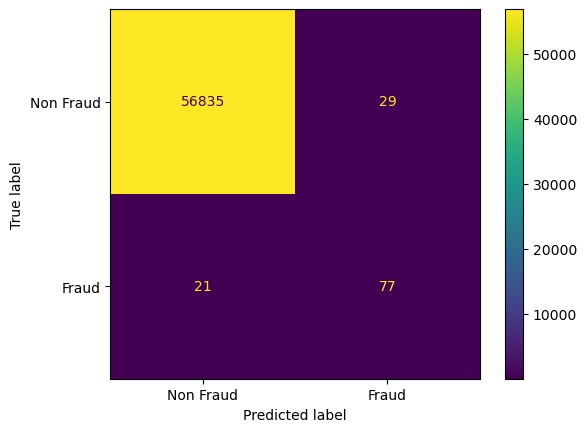

In [47]:
#Plot Confusion Matrix
pen_lr_cm = confusion_matrix(y_test, lr_pen_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=pen_lr_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

**g) Compare Model**

**INSIGHT:** When applying different techniques to due with imbalanced dataset for Logistic Regression, I realize that: 
- In this case, almost the resampling techniques will produces the result which is overffiting to minority class.
- Notably, SVMSMOTE stands out as yielding notably optimistic results in capturing large proportion of fraud cases with the highest precision.
- Logistic Regression with Penalty Adjustment emerges as the most optimal solution, surpassing the performance of the baseline model significantly.

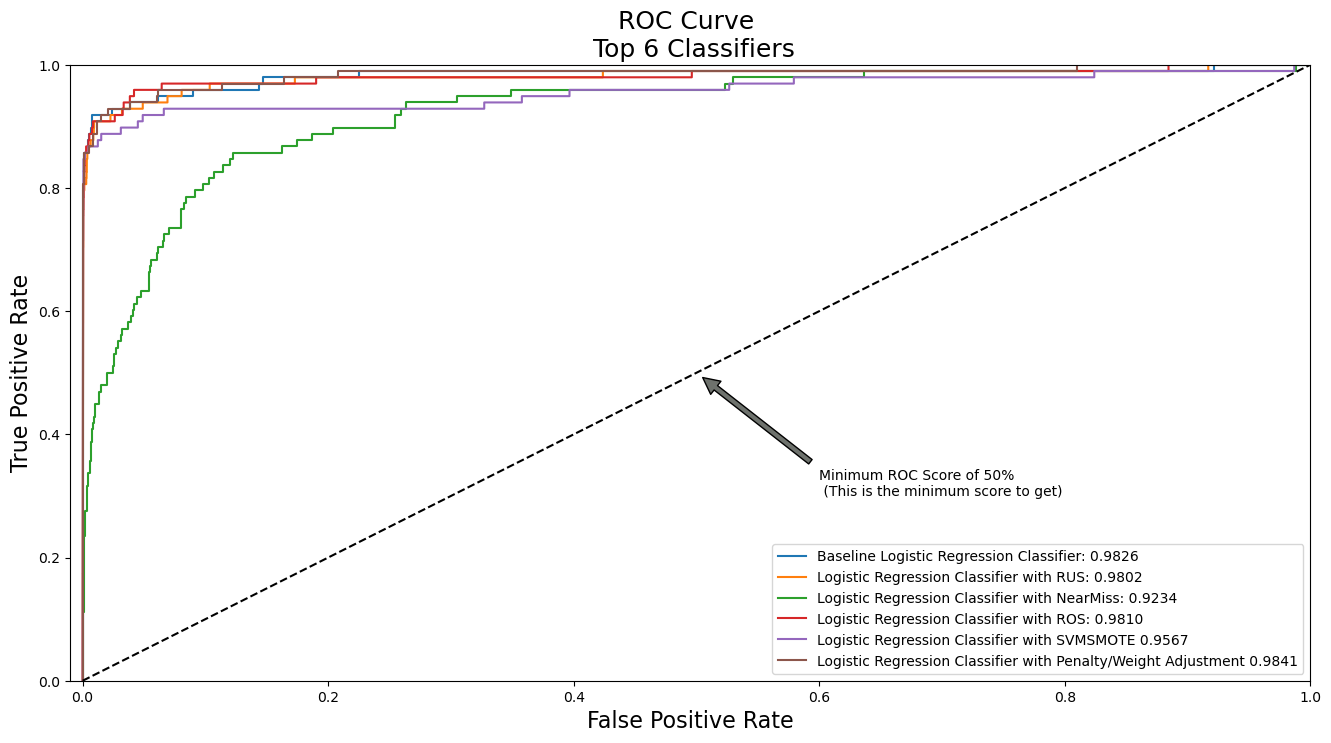

In [48]:
# Plot multiple roc curves
base_fpr, base_tpr, base_thresholds = roc_curve(y_test, y_test_pred_lr_prob)
rus_fpr, rus_tpr, rus_thresholds = roc_curve(y_test, rus_predictions[:,1])
nm_fpr, nm_tpr, nm_thresholds = roc_curve(y_test, nearmiss_predictions[:,1] )
ros_fpr, ros_tpr, ros_thresholds = roc_curve(y_test, ros_predictions[:,1])
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm_predictions[:,1])
pen_fpr, pen_tpr, pen_thresholds = roc_curve(y_test, lr_pen_predictions[:,1])


def graph_roc_curve_multiple(base_fpr, base_tpr, rus_fpr, rus_tpr ,nm_fpr, nm_tpr, ros_fpr, ros_tpr, svm_fpr, 
                             svm_tpr, pen_fpr, pen_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 6 Classifiers', fontsize=18)
    plt.plot(base_fpr, base_tpr, label='Baseline Logistic Regression Classifier: {:.4f}'.format(roc_auc_score(y_test, y_test_pred_lr_prob)))
    plt.plot(rus_fpr, rus_tpr, label='Logistic Regression Classifier with RUS: {:.4f}'.format(roc_auc_score(y_test, rus_predictions[:,1])))
    plt.plot(nm_fpr, nm_tpr, label='Logistic Regression Classifier with NearMiss: {:.4f}'.format(roc_auc_score(y_test, nearmiss_predictions[:,1])))
    plt.plot(ros_fpr, ros_tpr, label='Logistic Regression Classifier with ROS: {:.4f}'.format(roc_auc_score(y_test, ros_predictions[:,1])))
    plt.plot(svm_fpr, svm_tpr, label='Logistic Regression Classifier with SVMSMOTE {:.4f}'.format(roc_auc_score(y_test, svm_predictions[:,1])))
    plt.plot(pen_fpr, pen_tpr, label='Logistic Regression Classifier with Penalty/Weight Adjustment {:.4f}'.format(roc_auc_score(y_test, lr_pen_predictions[:,1])))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(base_fpr, base_tpr, rus_fpr, rus_tpr ,nm_fpr, nm_tpr, ros_fpr, ros_tpr, svm_fpr, 
                         svm_tpr, pen_fpr, pen_tpr)
plt.show()

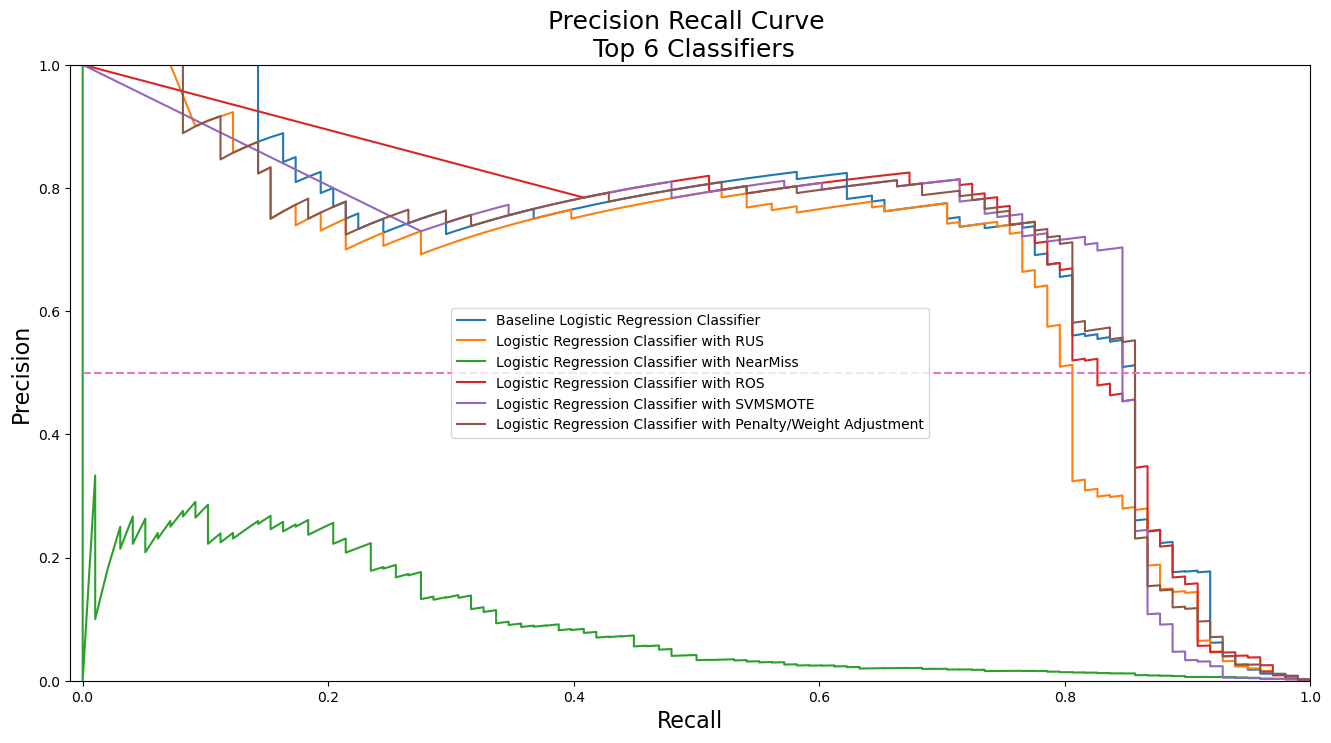

In [49]:
# Plot multiple precision recall curves
base_precision, base_recall, base_thresholds = precision_recall_curve(y_test, y_test_pred_lr_prob)
rus_precision, rus_recall, rus_thresholds = precision_recall_curve(y_test, rus_predictions[:,1])
nm_precision, nm_recall, nm_thresholds = precision_recall_curve(y_test, nearmiss_predictions[:,1] )
ros_precision, ros_recall, ros_thresholds = precision_recall_curve(y_test, ros_predictions[:,1])
svm_precision, svm_recall, svm_thresholds = precision_recall_curve(y_test, svm_predictions[:,1])
pen_precision, pen_recall, pen_thresholds = precision_recall_curve(y_test, lr_pen_predictions[:,1])

def graph_pre_curve_multiple(base_precision, base_recall,rus_precision, rus_recall, nm_precision, 
                             nm_recall, ros_precision, ros_recall, svm_precision, svm_recall,
                             pen_precision, pen_recall):
    plt.figure(figsize=(16,8))
    plt.title('Precision Recall Curve \n Top 6 Classifiers', fontsize=18)
    plt.plot(base_recall, base_precision, label='Baseline Logistic Regression Classifier')
    plt.plot(rus_recall, rus_precision, label='Logistic Regression Classifier with RUS')
    plt.plot(nm_recall, nm_precision, label='Logistic Regression Classifier with NearMiss')
    plt.plot(ros_recall, ros_precision, label='Logistic Regression Classifier with ROS')
    plt.plot(svm_recall, svm_precision, label='Logistic Regression Classifier with SVMSMOTE')
    plt.plot(pen_recall, pen_precision, label='Logistic Regression Classifier with Penalty/Weight Adjustment')
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.legend()
    
graph_pre_curve_multiple(base_precision, base_recall,rus_precision, rus_recall,nm_precision, 
                         nm_recall,ros_precision, ros_recall, svm_precision, svm_recall,
                         pen_precision, pen_recall)
plt.show()

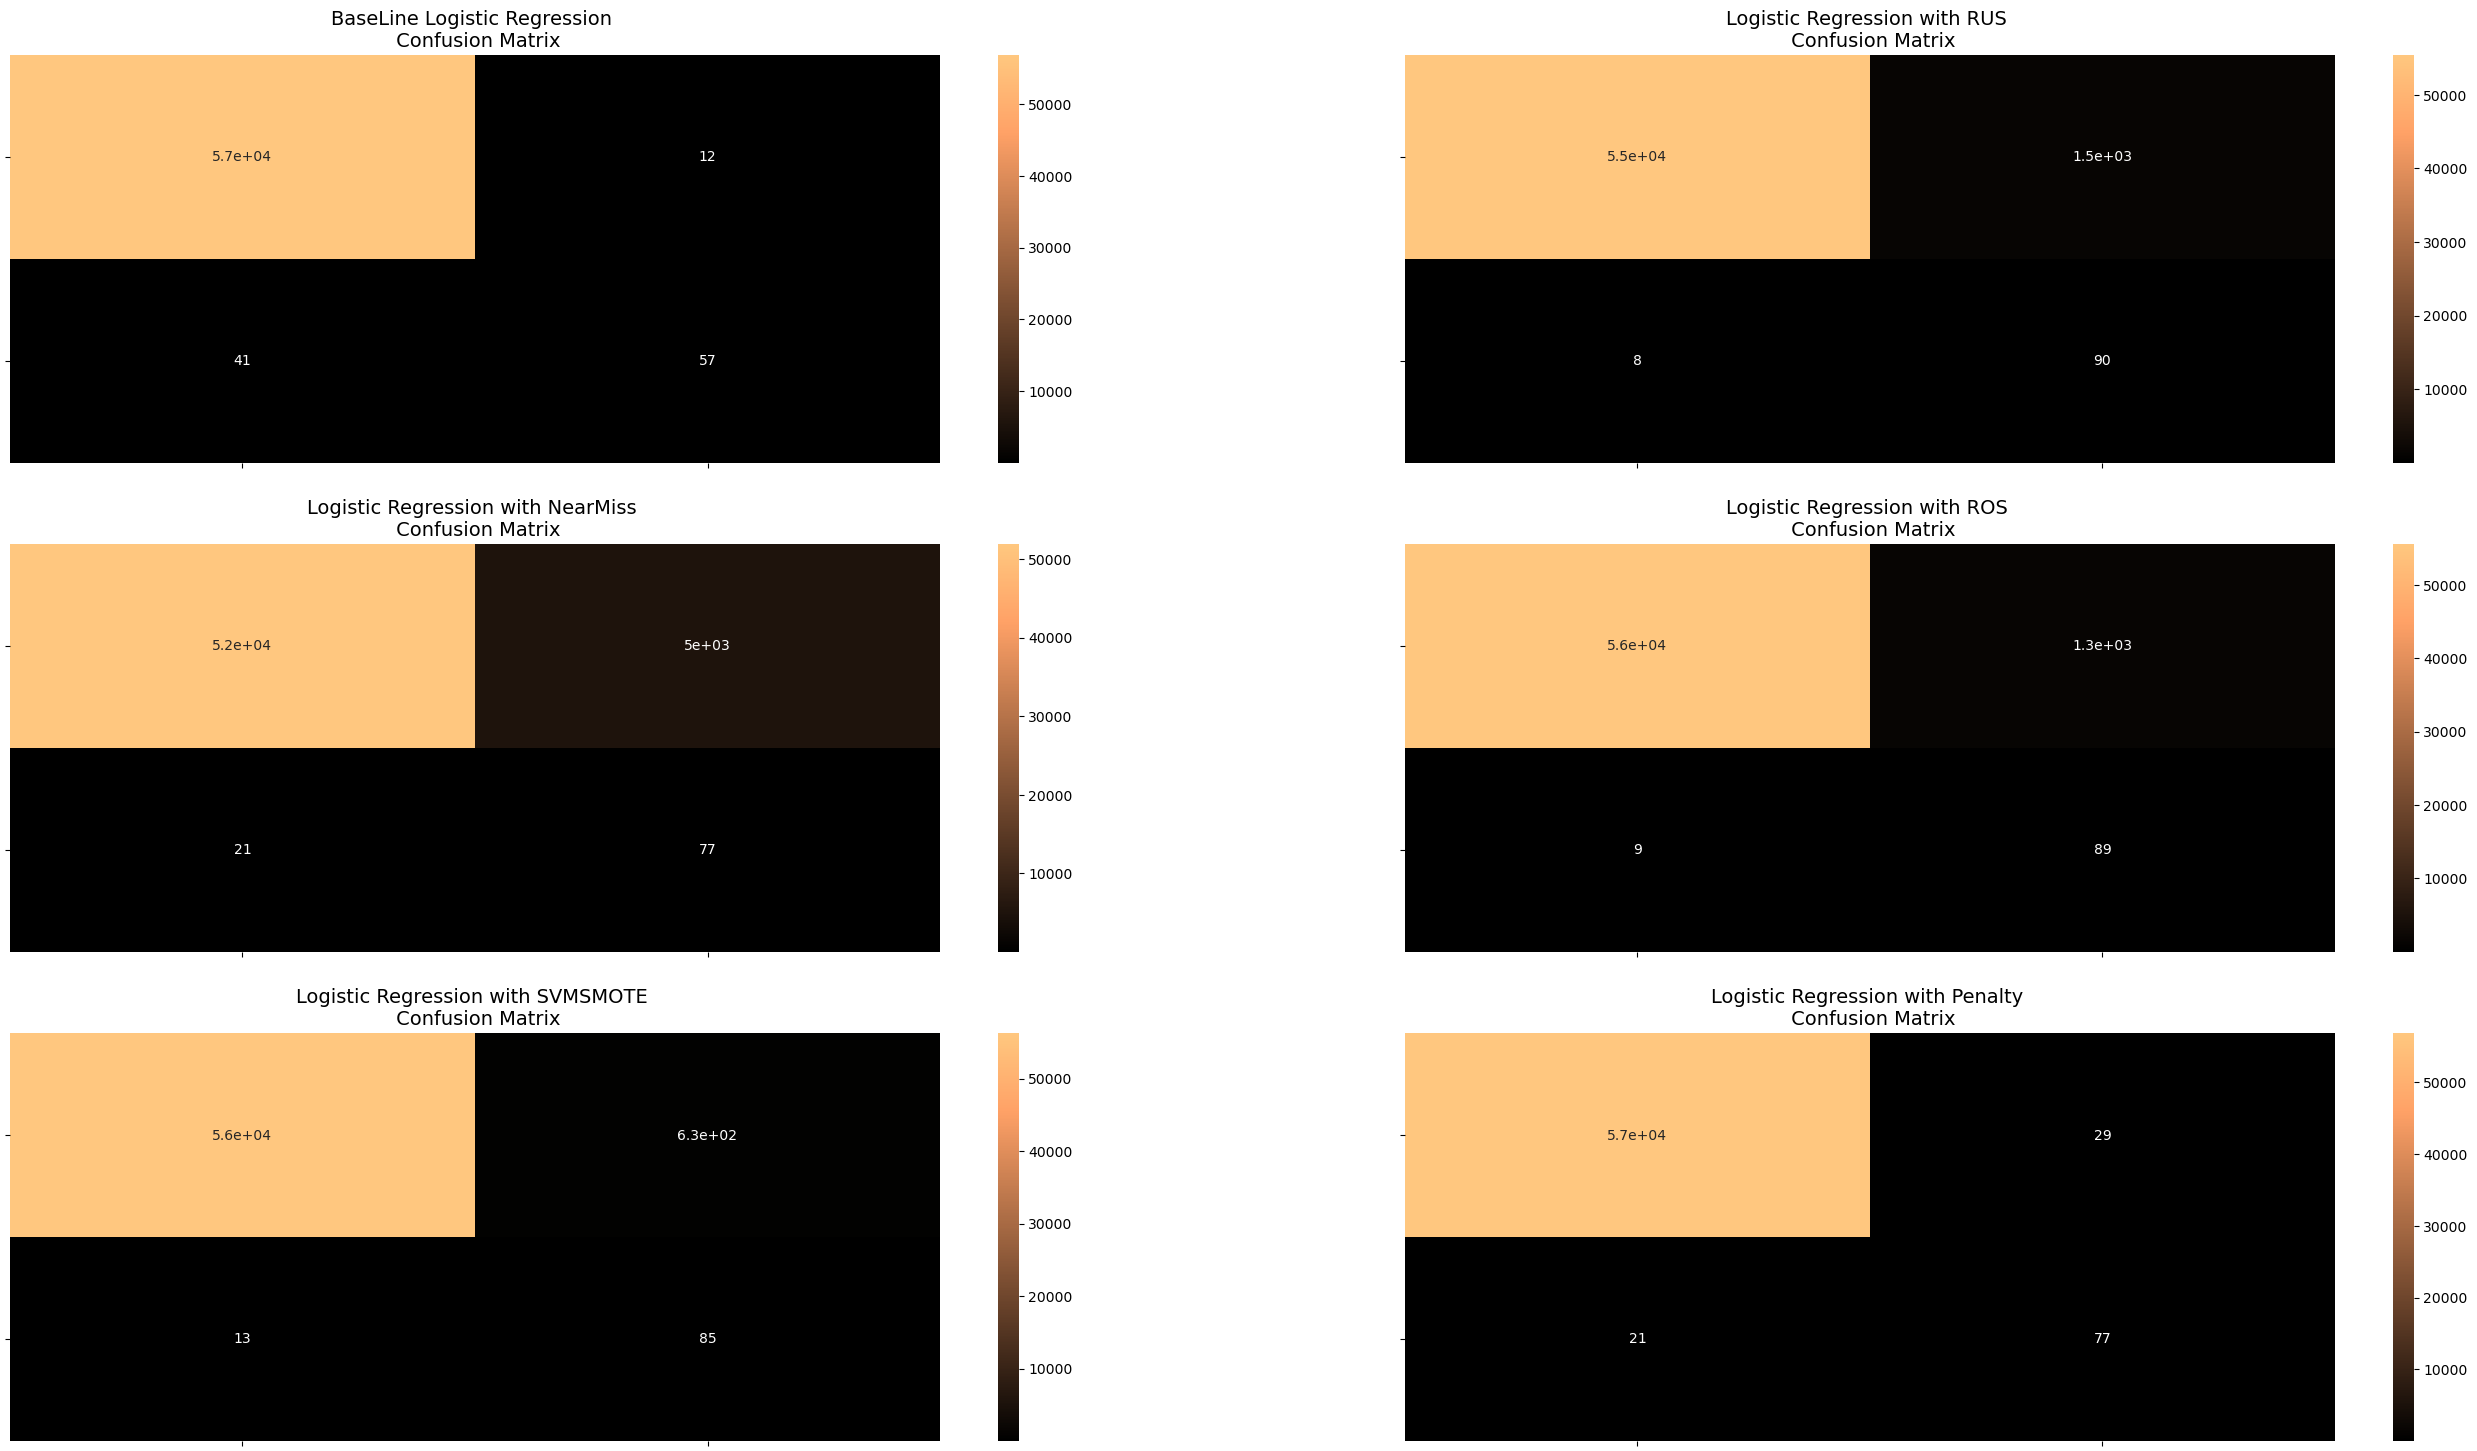

In [50]:
fig, ax = plt.subplots(3, 2,figsize=(33,18))


sns.heatmap(cm, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("BaseLine Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(rus_lr_cm, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("Logistic Regression with RUS \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(nm_lr_cm, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Logistic Regression with NearMiss \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(ros_lr_cm, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("Logistic Regression with ROS \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svm_lr_cm, ax=ax[2][0], annot=True, cmap=plt.cm.copper)
ax[2][0].set_title("Logistic Regression with SVMSMOTE \n Confusion Matrix", fontsize=14)
ax[2][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[2][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(pen_lr_cm, ax=ax[2][1], annot=True, cmap=plt.cm.copper)
ax[2][1].set_title("Logistic Regression with Penalty \n Confusion Matrix", fontsize=14)
ax[2][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[2][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

### VI. RANDOM FOREST CLASSIFICATION

In this section, I will apply the same techniques to Random Forest as I did with Logistic Regression previously and examine the differences in their performance.

**INSIGHT:**
- The baseline Random Forest model outperforms the baseline Logistic Regression model but it also need more time to train model 
- Across the board, most resampling techniques exhibit improved performance when paired with Random Forest compared to Logistic Regression. However, it's noteworthy that despite these enhancements, certain resampling methods like SMOTE and Random Under Sampling still manifest overfitting tendencies towards the minority class.
- Surprisingly, when it comes to optimizing for F1-score, NearMiss emerges as the most effective solution, contrary to the results observed with Logistic Regression.
- Similarly to Logistic Regression, introducing penalty adjustment to the Random Forest classifier yields performance improvements. 

In [51]:
# Implement and Evaluate Baseline RandomForest
rf_clf = RandomForestClassifier(n_estimators=100,
                                max_depth=5,
                                min_samples_split=200,
                                class_weight=None,
                                max_features=10)
rf_clf.fit(X_train, y_train)
rf_clf_pred_prob = rf_clf.predict_proba(X_test)
rf_clf_pred = rf_clf.predict(X_test) 


rf_roc_score = roc_auc_score(y_test, rf_clf_pred_prob[:,1])
print('rf roc score on test: ', rf_roc_score)
print(classification_report(y_test, rf_clf_pred))

rf roc score on test:  0.9567811455617701
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.67      0.71        98

    accuracy                           1.00     56962
   macro avg       0.88      0.84      0.86     56962
weighted avg       1.00      1.00      1.00     56962



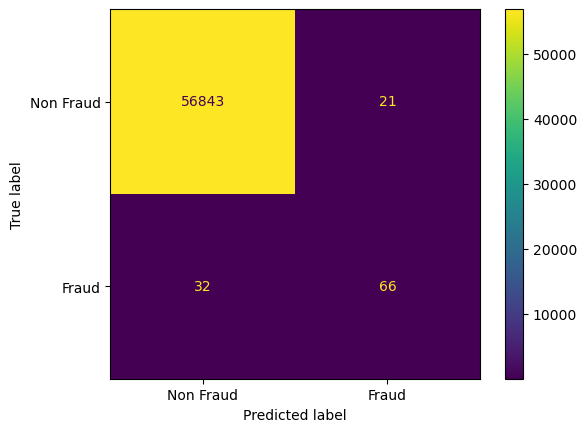

In [52]:
# Plot Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_clf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

In [53]:
# Random Forest with Random Under Sampling
rus_rf = rf_clf.fit(X_train_rus, y_train_rus)
rus_rf_predictions = rf_clf.predict_proba(X_test)
rus_rf_pred_label = rf_clf.predict(X_test) 
rus_rf_roc_score = roc_auc_score(y_test, rus_rf_predictions[:,1])
print('RF with Random Under Sampling roc score on test: ', rus_rf_roc_score)
print(classification_report(y_test, rus_rf_pred_label)) 

RF with Random Under Sampling roc score on test:  0.9749569865228027
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.88      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.59     56962
weighted avg       1.00      0.99      0.99     56962



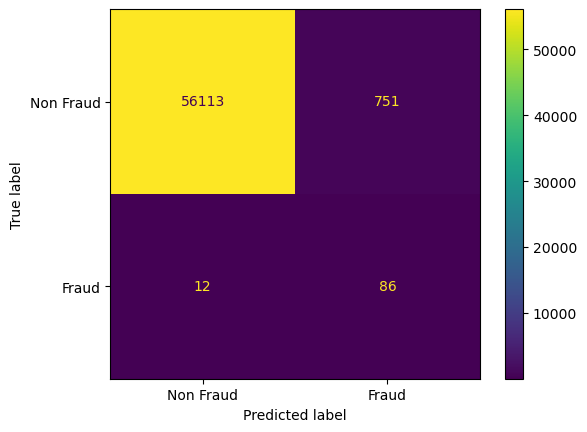

In [54]:
# Plot Confusion Matrix
rus_rf_cm = confusion_matrix(y_test, rus_rf_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=rus_rf_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

In [55]:
# Random Forest with NearMiss
nm_rf = rf_clf.fit(X_train_nearmiss, y_train_nearmiss)
nm_rf_predictions = nm_rf.predict_proba(X_test)
nm_rf_pred_label = nm_rf.predict(X_test) 
nm_rf_roc_score = roc_auc_score(y_test, nm_rf_predictions[:,1])
print('RF with NearMiss roc score on test: ', nm_rf_roc_score)
print(classification_report(y_test, nm_rf_pred_label)) 

RF with NearMiss roc score on test:  0.9367393236135197
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.71      0.79      0.75        98

    accuracy                           1.00     56962
   macro avg       0.86      0.89      0.87     56962
weighted avg       1.00      1.00      1.00     56962



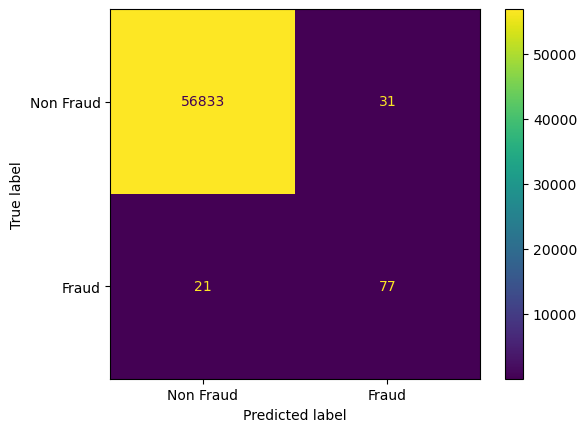

In [56]:
# Plot Confusion Matrix
nm_rf_cm = confusion_matrix(y_test, nm_rf_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=nm_rf_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

In [57]:
# Random Forest with Random Over Sampling
ros_rf = rf_clf.fit(X_train_ros, y_train_ros)
ros_rf_predictions = ros_rf.predict_proba(X_test)
ros_rf_pred_label = ros_rf.predict(X_test) 
ros_rf_roc_score = roc_auc_score(y_test, ros_rf_predictions[:,1])
print('RF with  Random Over Sampling roc score on test: ', ros_rf_roc_score)
print(classification_report(y_test, ros_rf_pred_label)) 

RF with  Random Over Sampling roc score on test:  0.9749487319547966
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.32      0.87      0.46        98

    accuracy                           1.00     56962
   macro avg       0.66      0.93      0.73     56962
weighted avg       1.00      1.00      1.00     56962



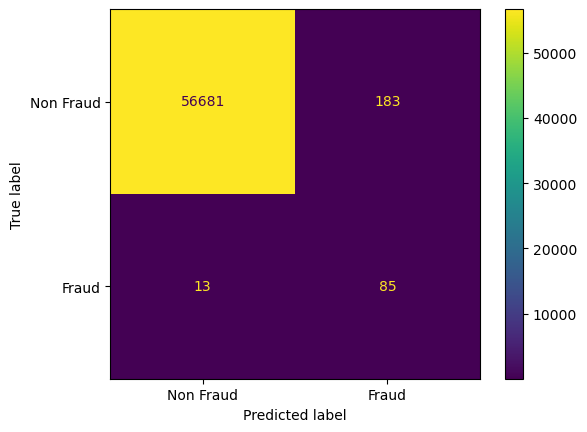

In [58]:
# Plot Confusion Matrix
ros_rf_cm = confusion_matrix(y_test, ros_rf_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=ros_rf_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

In [59]:
# Random Forest with SMOTE
for i, sampler in enumerate((SMOTE(sampling_strategy = 1, random_state=0),
                BorderlineSMOTE(sampling_strategy = 1, random_state=0, kind='borderline-1'),
                SVMSMOTE(sampling_strategy = 1, random_state=0),
                ADASYN(sampling_strategy = 1, random_state=0))):
    pipe_line = make_pipeline(sampler, rf_clf)
    pipe_line.fit(X_train, y_train)
    rf_predictions = pipe_line.predict_proba(X_test)
    rf_pred_label = pipe_line.predict(X_test) 
    rf_roc_score = roc_auc_score(y_test, rf_predictions[:,1])
    print('------------------------------------------------')
    print('SMOTE method: ', smotes[i])
    print('RF roc score on test: ', rf_roc_score)
    print(classification_report(y_test, rf_pred_label))

------------------------------------------------
SMOTE method:  SMOTE
RF roc score on test:  0.975840763640853
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.22      0.88      0.35        98

    accuracy                           0.99     56962
   macro avg       0.61      0.94      0.67     56962
weighted avg       1.00      0.99      1.00     56962

------------------------------------------------
SMOTE method:  BorderlineSMOTE
RF roc score on test:  0.9691018958230451
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.17      0.87      0.28        98

    accuracy                           0.99     56962
   macro avg       0.58      0.93      0.64     56962
weighted avg       1.00      0.99      0.99     56962

------------------------------------------------
SMOTE method:  SVMSMOTE
RF roc score on test:  0.976311094570073

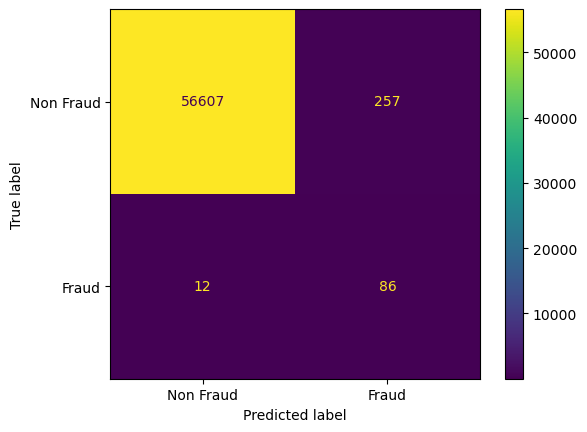

In [60]:
# Plot Confusion Matrix for SMOTE
smote = SMOTE(sampling_strategy = 1, random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

smote_rf = rf_clf.fit(X_train_smote, y_train_smote)
smote_predictions = smote_rf.predict_proba(X_test)
smote_pred_label = smote_rf.predict(X_test) 

smote_rf_cm = confusion_matrix(y_test, smote_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix= smote_rf_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

In [61]:
# Random Forest with Penalty Adjustment
rf_pen = RandomForestClassifier(n_estimators=100, 
                                max_depth=5, 
                                min_samples_split=200, 
                                random_state=12, 
                                class_weight={0: 0.1,
                                              1: 0.9},
                                max_features=10)

rf_pen.fit(X_train, y_train)
rf_pen_pred_prob = rf_pen.predict_proba(X_test)
rf_pen_pred = rf_pen.predict(X_test) 

rf_pen_roc_score = roc_auc_score(y_test, rf_pen_pred_prob[:,1])
print('rf roc score on test: ', rf_pen_roc_score)
print(classification_report(y_test, rf_pen_pred)) 

rf roc score on test:  0.9641052801959274
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.80      0.76        98

    accuracy                           1.00     56962
   macro avg       0.86      0.90      0.88     56962
weighted avg       1.00      1.00      1.00     56962



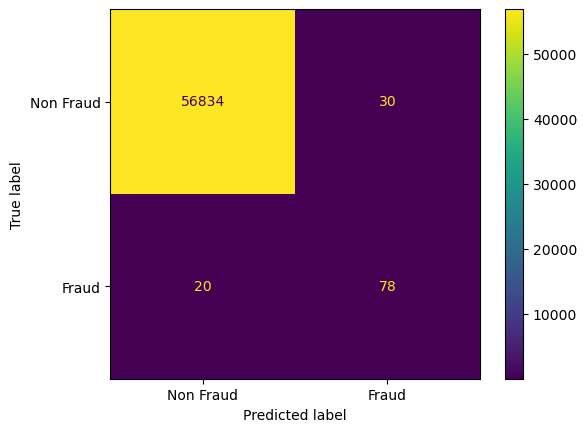

In [62]:
# Plot Confusion Matrix
pen_rf_cm = confusion_matrix(y_test, rf_pen_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=pen_rf_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

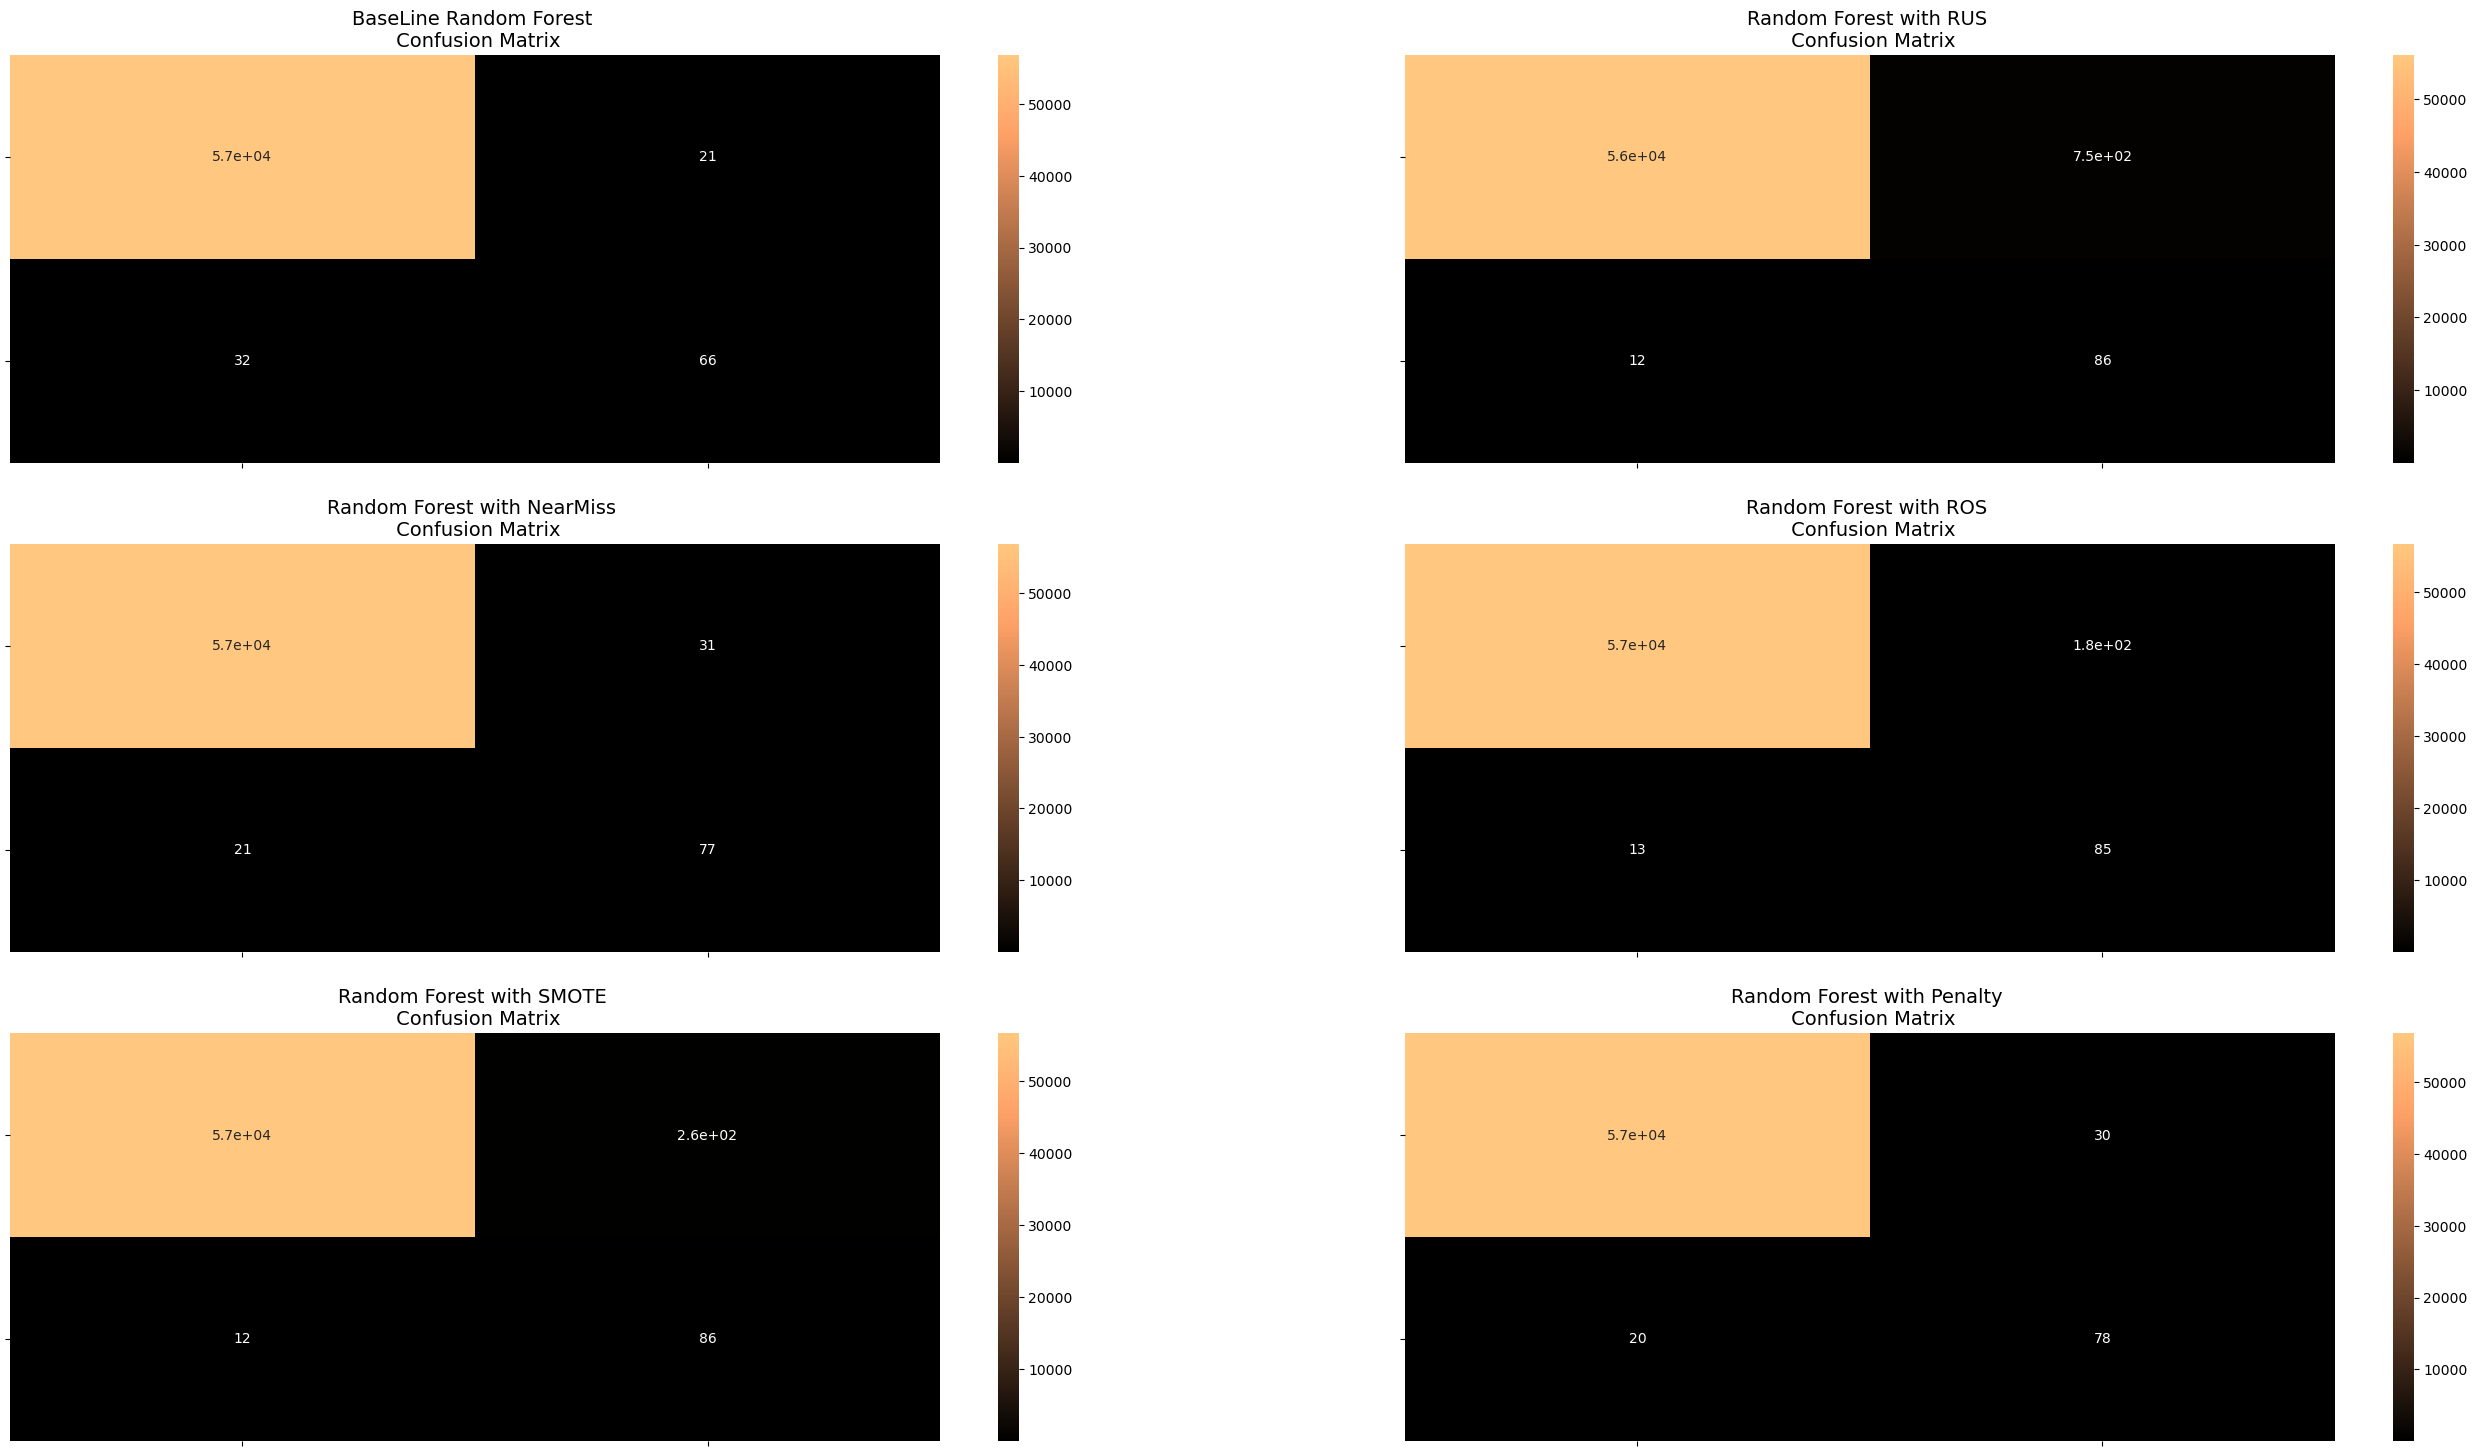

In [63]:
# Model Comparision
fig, ax = plt.subplots(3, 2,figsize=(33,18))


sns.heatmap(rf_cm, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("BaseLine Random Forest \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(rus_rf_cm, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("Random Forest with RUS \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(nm_rf_cm, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Random Forest with NearMiss \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(ros_rf_cm, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("Random Forest with ROS \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(smote_rf_cm, ax=ax[2][0], annot=True, cmap=plt.cm.copper)
ax[2][0].set_title("Random Forest with SMOTE \n Confusion Matrix", fontsize=14)
ax[2][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[2][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(pen_rf_cm, ax=ax[2][1], annot=True, cmap=plt.cm.copper)
ax[2][1].set_title("Random Forest with Penalty \n Confusion Matrix", fontsize=14)
ax[2][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[2][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

###  VII. XG Boost

**INSIGHT**
- The baseline XGBoost model demonstrates superior performance in fraud detection compared to baseline Logistic Regression and Random Forest models.

- However, when employing under-sampling techniques such as NearMiss or Random Under Sampling with XGBoost, these methods prove ineffective in addressing the issue of imbalanced datasets, often resulting in overfitting to minority cases.

- While algorithms like RUS, Borderline SMOTE, and SVMSMOTE can enhance the model's ability to detect fraud cases, there is a trade-off in precision.

In [64]:
#Baseline XG Boost
xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=9,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb = xgb.fit(X_train, y_train)

In [65]:
#Evaluate baseline XG Boost performance
xgb_predictions = xgb.predict_proba(X_test)
xgb_pred_label = xgb.predict(X_test) 
xgb_roc_score = roc_auc_score(y_test, xgb_predictions[:,1])
print('XGB roc score on test: ', xgb_roc_score)
print(classification_report(y_test, xgb_pred_label))

XGB roc score on test:  0.9747449697380359
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.80      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



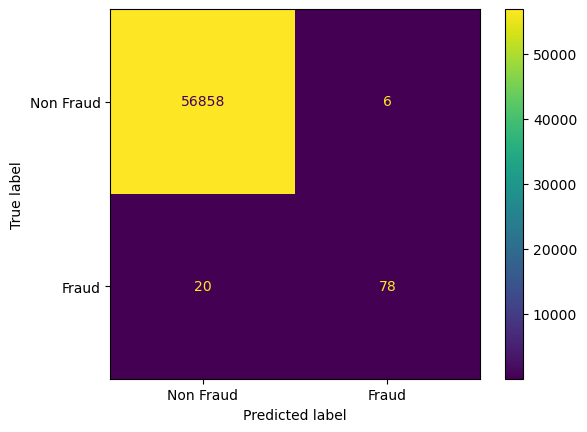

In [66]:
# Plot Confusion Matrix
xgb_cm = confusion_matrix(y_test, xgb_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix= xgb_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

In [67]:
#XGB with Random Under Sampling
rus_xgb = xgb.fit(X_train_rus, y_train_rus)
rus_xgb_predictions = rus_xgb.predict_proba(X_test)
rus_xgb_pred_label = rus_xgb.predict(X_test) 
rus_xgb_roc_score = roc_auc_score(y_test, rus_xgb_predictions[:,1])
print('XGB with Random Under Sampling roc score on test: ', rus_xgb_roc_score)
print(classification_report(y_test, rus_xgb_pred_label)) 

XGB with Random Under Sampling roc score on test:  0.9796115759190565
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.91      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962



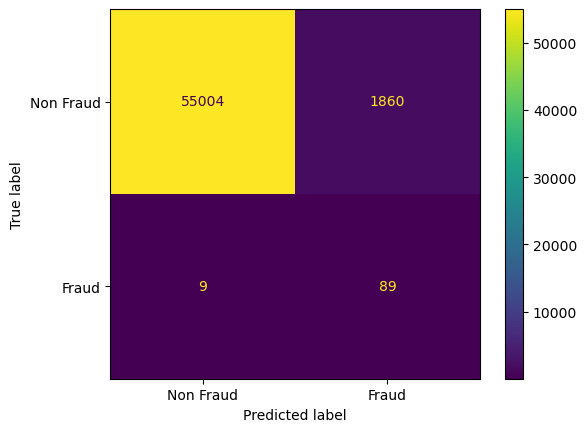

In [68]:
# Plot Confusion Matrix
rus_xgb_cm = confusion_matrix(y_test, rus_xgb_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix= rus_xgb_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

In [69]:
#XGB with NearMiss
nm_xgb = xgb.fit(X_train_nearmiss, y_train_nearmiss)
nm_xgb_predictions = nm_xgb.predict_proba(X_test)
nm_xgb_pred_label = nm_xgb.predict(X_test) 
nm_xgb_roc_score = roc_auc_score(y_test, nm_xgb_predictions[:,1])
print('XGB with NearMiss roc score on test: ', nm_xgb_roc_score)
print(classification_report(y_test, nm_xgb_pred_label)) 

XGB with NearMiss roc score on test:  0.9489209126250387
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.04      0.88      0.08        98

    accuracy                           0.97     56962
   macro avg       0.52      0.92      0.53     56962
weighted avg       1.00      0.97      0.98     56962



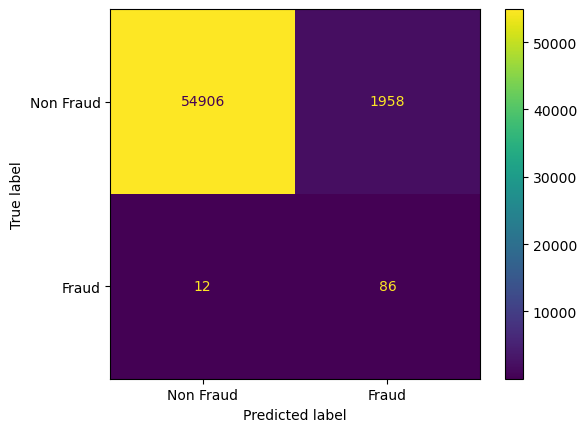

In [70]:
# Plot Confusion Matrix
nm_xgb_cm = confusion_matrix(y_test, nm_xgb_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix= nm_xgb_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

In [71]:
#XGB with Random Over Sampling
ros_xgb = xgb.fit(X_train_ros, y_train_ros)
ros_xgb_predictions = ros_xgb.predict_proba(X_test)
ros_xgb_pred_label = ros_xgb.predict(X_test) 
ros_xgb_roc_score = roc_auc_score(y_test, ros_xgb_predictions[:,1])
print('XGB with Random Over Sampling roc score on test: ', ros_xgb_roc_score)
print(classification_report(y_test, ros_xgb_pred_label)) 

XGB with Random Over Sampling roc score on test:  0.9774163991708107
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



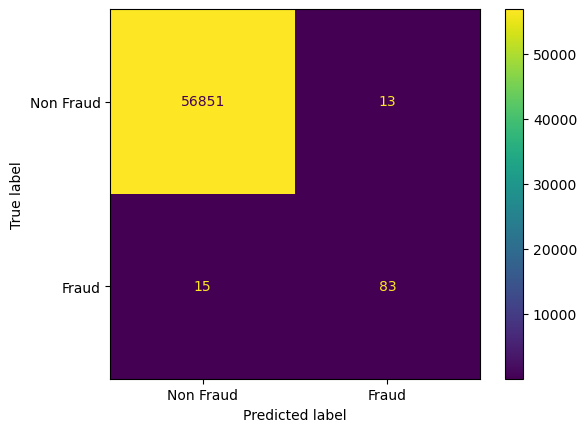

In [72]:
# Plot Confusion Matrix
ros_xgb_cm = confusion_matrix(y_test, ros_xgb_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix= ros_xgb_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

In [73]:
#XGB with SMOTE
for i, sampler in enumerate((SMOTE(sampling_strategy = 1, random_state=0),
                BorderlineSMOTE(sampling_strategy = 1, random_state=0, kind='borderline-1'),
                SVMSMOTE(sampling_strategy = 1, random_state=0),
                ADASYN(sampling_strategy = 1, random_state=0))):
    pipe_line = make_pipeline(sampler, xgb)
    pipe_line.fit(X_train, y_train)
    xgb_predictions = pipe_line.predict_proba(X_test)
    xgb_pred_label = pipe_line.predict(X_test) 
    xgb_roc_score = roc_auc_score(y_test, xgb_predictions[:,1])
    print('------------------------------------------------')
    print('SMOTE method: ', smotes[i])
    print('XGB roc score on test: ', xgb_roc_score)
    print(classification_report(y_test, xgb_pred_label))

------------------------------------------------
SMOTE method:  SMOTE
XGB roc score on test:  0.9797904847082333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.61      0.85      0.71        98

    accuracy                           1.00     56962
   macro avg       0.81      0.92      0.86     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------
SMOTE method:  BorderlineSMOTE
XGB roc score on test:  0.976403779013012
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.86      0.84        98

    accuracy                           1.00     56962
   macro avg       0.91      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962

------------------------------------------------
SMOTE method:  SVMSMOTE
XGB roc score on test:  0.977014796492

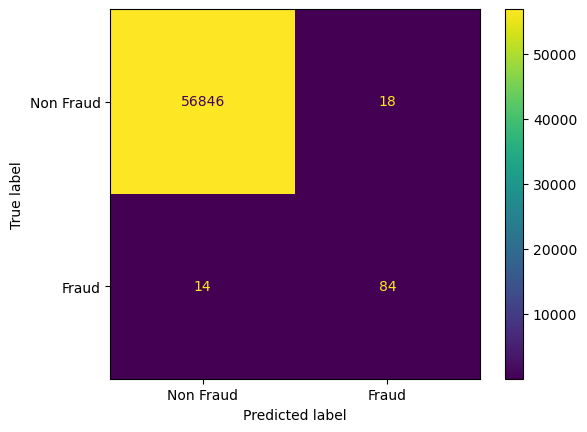

In [74]:
# Plot Confusion Matrix
svm_xgb = xgb.fit(X_train_svmsmote, y_train_svmsmote)
svm_xgb_predictions =svm_xgb.predict_proba(X_test)
svm_xgb_pred_label = svm_xgb.predict(X_test) 

svm_xgb_cm = confusion_matrix(y_test, svm_xgb_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=svm_xgb_cm, display_labels=["Non Fraud", "Fraud"])
disp.plot()

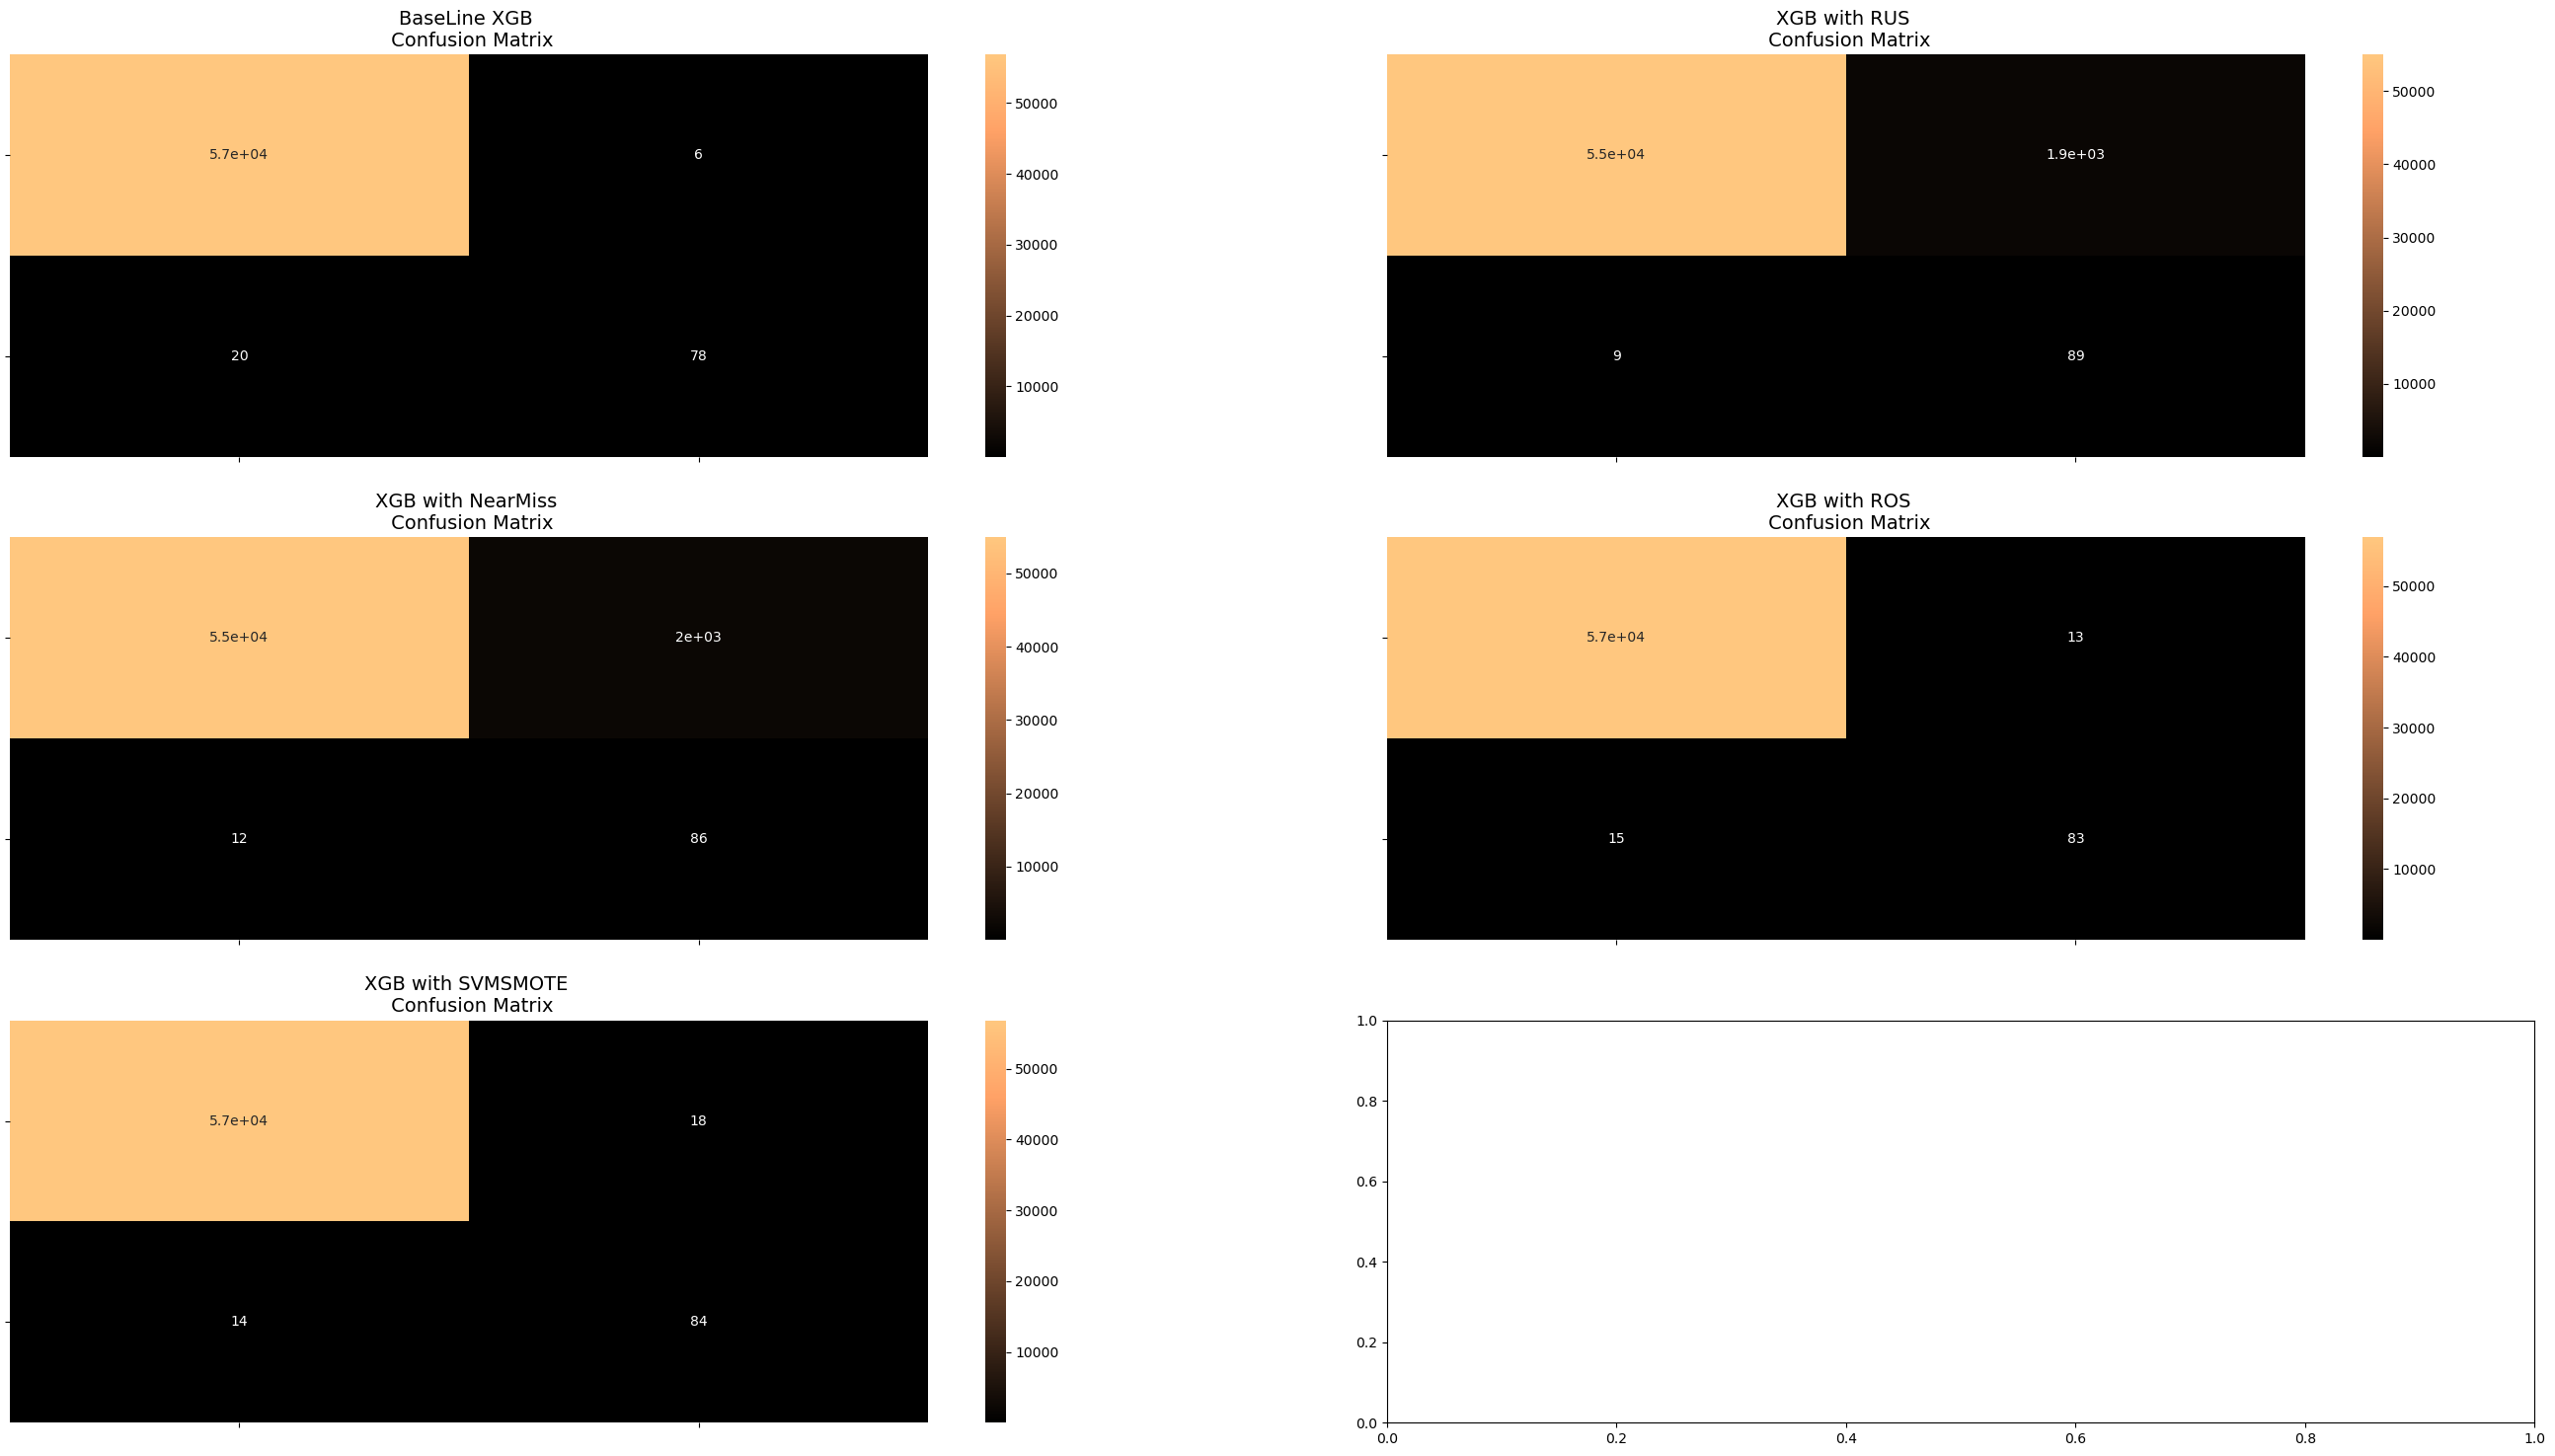

In [75]:
# Model Comparision
fig, ax = plt.subplots(3, 2,figsize=(33,18))


sns.heatmap(xgb_cm, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("BaseLine XGB \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(rus_xgb_cm, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("XGB with RUS \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(nm_xgb_cm, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("XGB with NearMiss \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(ros_xgb_cm, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("XGB with ROS \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svm_xgb_cm, ax=ax[2][0], annot=True, cmap=plt.cm.copper)
ax[2][0].set_title("XGB with SVMSMOTE \n Confusion Matrix", fontsize=14)
ax[2][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[2][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

## CONCLUSION

In addressing the challenge of imbalanced datasets in fraud detection, our project has explored various techniques across different algorithms to enhance model performance. We have implemented three key algorithms: Logistic Regression, Ensemble Learning (specifically Bagging with Random Forest and Boosting with XGBoost).

Logistic Regression, while delivering the lowest performance among the algorithms tested, offers the advantage of simplicity and faster training times. Notably, incorporating penalties into the model has proven to be the most effective strategy for improvement. However, it's worth mentioning that resampling techniques, while beneficial, tend to exhibit a propensity for overfitting to the minority class, particularly in fraud cases.

Random Forest, on the other hand, presents a more promising baseline compared to Logistic Regression. Although it demands more computation time, resampling techniques, particularly NearMiss, have shown remarkable efficacy in enhancing its performance compared to the baseline model.

XGBoost stands out with its superior performance in fraud detection compared to both Logistic Regression and Random Forest models. Yet, similar to Random Forest, it struggles with the issue of overfitting when employing under-sampling techniques like NearMiss or Random Under Sampling. Despite this, approaches such as RUS, Borderline SMOTE, and SVMSMOTE can indeed improve the model's ability to detect fraud cases, albeit with a potential trade-off in precision.

In selecting the optimal solution for our specific case, considerations such as the cost associated with failing to detect fraud or incorrectly flagging non-fraudulent transactions, as well as the objectives and requirements of the company, are paramount. This scenario embodies the classic trade-off between precision and recall, where a nuanced understanding of the business context is essential to strike the right balance.

There are possiple classifiers company can choose:
- Logistic Regression with penalty adjustment - F1-score 0,75 (Fastest Traning Time)
- XGB with Random Over Sampling - F1-score 0,86 (Highest recall)
- Baseline XGB - F1-score 0,86 (Highest precision)